# AC209b Final Project -  Law Citation Prediction

Group 6: Jiahui Tang, Yingchen Liu, Yujie Cai, Xin Zeng

Github Repository: https://github.com/LawCitationPrediction/Project

## Executive Summary

In this report, we would use a dataset from Harvard Law School Case Law Access Project. The main data sets we used here for modeling are the latest case metadata and text for each case by the jurisdiction in North Carolina. The data basically consisted of two parts: header and opinion. We performed a PCA analysis to determine whether we should use the header as a predictor. We then conduct various data preprocessing methods to handle text data.

We then describe our modeling approach and go over the logical description of modeling decisions and process following the order of baseline model, improved baseline models (LexNLP, Topic Modeling, Word2Vec), Text Classification Method (FFNN / LSTM / BERT with FFNN/LSTM in the Appendix: Models), BERT for Document Similarity, and lastly, our proposed LawPairBERT Model. 

Our LawPairBERT model has two version, one with BERT Embedding and another one with both BERT and Graph Embedding. Our LawPairBERT model has many advantages which overcomes the problems and concerns of other models we experiment. LawPairBERT model could directly captures the citation relationship among each pair of law cases. And it achieves high accuracy in predicting both true and false condition of citation. Moreover, through the Pairs Representation we designed using Imbalanced Random Concatenation, we could reduce computational cost while remaining high accuracy. We regard it as a good contribution and treat it as our final deliverable model.

One additional note is that we meet the requirements of 209 course through various aspects. On the one hand, we creatively designed a representation called LawPairBERT for capturing the pair relationship between cases. Our LawPairBERT model improves the accuracy and reduces the computational cost greatly. On the other hand, we learned and experimented many methods outside from our lectures, like topic modeling and graph embedding.

# Notebook contents

[Executive Summary](#Executive-Summary)

[Case Law Citation Prediction](#Case-Law-Citation-Prediction)

[Data Processing](#Data-Processing)

  - [Downloading data](#Downloading-data)

  - [Loading data](#Loading-data)

  - [EDA](#EDA) (also in appendix)

  - [Data Processing for Modeling](#Data-Processing-for-Modeling)

[Model: Baseline with Word2Vec](#Model:-Baseline-with-Word2Vec)

  - [Step1: Explore LEXNLP tools](#Step1:-Explore-LEXNLP-tools)

  - [Step2: Explore Topic Modeling](#Step2:-Explore-Topic-Modeling)

  - [Step3: Word Embedding using Law2Vec](#Step3:-Word-Embedding-using-Law2Vec)

  - [Step4: Prediction of Citation using Word2Vec](#Step4:-Prediction-of-Citation-using-Word2Vec)

[Explore: Clustering based on header information](#Explore:-Clustering-based-on-header-information)

[Model: BERT for text classification](#Model:-BERT-for-text-classification)

[Model: BERT for Document Similarity](#Model:-BERT-for-Document-Similarity)

[Model: Our Proposed Model - LawPairBERT Model with BERT Embedding](#Model:-Our-Proposed-Model---LawPairBERT-Model-with-BERT-Embedding)

 - [Method 1: FFNN](#Method-1:-FFNN)
 
 - [Method 2: FFNN with self-defined early-stopping condition (recall)](#Method-2:-FFNN-with-self-defined-early-stopping-condition-(recall))
 
 - [Method 3: LSTM Model](#Method-3:-LSTM-Model)
    
[Additional Thinking](#Additional-Thinking)

[Model: Our Proposed Model - LawPairBERT Model with BERT and Graph Embedding](#Model:-Our-Proposed-Model---LawPairBERT-Model-with-BERT-and-Graph-Embedding)

 - [Graph Embedding Generation](#Graph-Embedding-Generation)
 
 - [Method 1: FFNN (2)](#Method-1:-FFNN-(2))
 
 - [Method 2: FFNN with self-defined early-stopping condition (recall) (2)](#Method-2:-FFNN-with-self-defined-early-stopping-condition-(recall)-(2))
 
 - [Method 3: LSTM Model (2)](#Method-3:-LSTM-Model-(2))
    
[Appendix](#Appendix)
 
 - [Model: FFNN for text classification](#Model:-FFNN-for-text-classification)
 
 - [Model: LSTM for text classification](#Model:-LSTM-for-text-classification)
 
 - [EDA](#EDA)
 
 



## Case Law Citation Prediction 
In the common law legal system, judges decide issues between case law by reference to previous decisions that consider similar factual situations. However, there is no existing system to help judges quickly find the most relevant citations. In this project, we will focus on processing case law and legal precedent data and attempt to develop an automated relevant legal citation generator. With this system, we will be able to automate the process from citation retrieving to decision making.

In [1]:
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import lzma
import json
import requests
from tqdm import tqdm
from collections import Counter
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import os
%matplotlib inline

In [2]:
from tensorflow.keras.optimizers import Adam
import tensorflow

In [3]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, \
                            TimeDistributed, GRU, Dropout, Bidirectional, \
                            Conv1D, BatchNormalization
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

## Data Processing

[Return to top](#Notebook-contents)

## Downloading data

[Return to top](#Notebook-contents)

First let's download the latest text export for the state of North Carolina. You could also download files
manually from your browser.

In [4]:
# ark/, ill/, nc/, nm/
#state_names = ['ark', 'ill', 'nc', 'nm']
state_names = ['nc']
for state in state_names:
  download_url = "https://case.law/download/bulk_exports/20210421/by_jurisdiction/case_text_open/"+ state + "/" + state + "_text_20210421.zip"
  output_path = "data/"+ state+"_text.zip"
  print("Downloading to %s ..." % output_path)
  with open(output_path, 'wb') as out_file:
      shutil.copyfileobj(requests.get(download_url, stream=True).raw, out_file)
  print("Done.")



Done.


## Loading data

[Return to top](#Notebook-contents)

Our bulk export is stored as a zipped folder in [BagIt](https://en.wikipedia.org/wiki/BagIt) format, which in turn
contains an xzipped file in [jsonlines](http://jsonlines.org/) format. We can peel off all of those layers and get
a list of cases with built-in Python libraries.

Let's pull 1-year batches of cases at 10 year intervals from 1900 to 2000. This should give us a good sampling over time.

In [5]:
# a list to hold the cases we're sampling
# decompress the file line by line
def load_cases(state):
  cases = []
  filename = 'data/'+ state +'_text.zip'
  with zipfile.ZipFile(filename, 'r') as zip_archive:
      xz_path = next(path for path in zip_archive.namelist() if path.endswith('/data.jsonl.xz'))
      with zip_archive.open(xz_path) as xz_archive, lzma.open(xz_archive) as jsonlines:
          for line in tqdm(jsonlines):
              # decode the file into a convenient format
              record = json.loads(str(line, 'utf-8'))
              # if the decision date on the case matches one we're interested in, add to our list
              if int(record['decision_date'][:4]) in range(1900, 2010, 10):
                  cases.append(record)  
  print(filename+'\n')
  print("Number of Cases: {}".format(len(cases)))
  return cases

cases = []
for state in state_names:
  cases+=load_cases(state)
print(len(cases))

97429it [00:38, 2500.70it/s]

data/nc_text.zip

Number of Cases: 7100
7100



## Data Processing for Modeling

[Return to top](#Notebook-contents)

In [6]:
opinion_data = []
for case in cases:
    for opinion in case["casebody"]["data"]["opinions"]:
        opinion_data.append({
            'id': case['id'],
            'name': case['name'],
            'decision_date': int(case['decision_date'][:4]),
            'court': case['court']['name'],
            'citation': case['citations'],
            'cites_to': case['cites_to'],
            'author': opinion['author'],
            'type': opinion['type'],
            'text': opinion['text'],
        })

opinions_df = pd.DataFrame(opinion_data)
opinions_df.head()

id  ...                                               text
0  8521088  ...  ERWIN, Judge.\nThe question presented for our ...
1  8564338  ...  EXUM, Justice.\nThis appeal presents two quest...
2  8561053  ...  EXUM, Justice.\nThe sole question presented by...
3  8597345  ...  Barnhill, J.\nWhile the complaint does not und...
4  8561636  ...  SHARP, J.\nThe opinion and award of the full C...

[5 rows x 9 columns]

In [7]:
import numpy as np
import re
opinions_df["cites_list"] = None

for i in opinions_df.index:
    cites_list = opinions_df.loc[i, "cites_to"]
    temp_list = []
    opinions_df.loc[i, "text"] = re.sub(r' \w+ v\. .*?\,', '', opinions_df.loc[i, "text"])
    for j in range(len(cites_list)):
        opinions_df.loc[i, "text"] = re.sub(cites_list[j]['cite'] + " \([0-9]+\)", '', opinions_df.loc[i, "text"])
        opinions_df.loc[i, "text"] = re.sub(cites_list[j]['cite'], '', opinions_df.loc[i, "text"])
        temp_list.append(cites_list[j]['cite'])
    opinions_df.at[i, "cites_list"] = temp_list

In [8]:
opinions_df.head()

id  ...                                         cites_list
0  8521088  ...  [295 N.C. 733, 215 S.E. 2d 583, 288 N.C. 62, 2...
1  8564338  ...  [116 N.W. 98, 17 N.D. 302, 550 F. 2d 929, 70 S...
2  8561053  ...  [292 N.C. 265, 41 N.C. App. at 211, 225 S.E. 2...
3  8597345  ...  [157 S. E., 31, 200 N. C., 340, 160 S. E., 367...
4  8561636  ...  [15 A. L. R. 3d 616, 258 N.C. 741, 159 S.E. 2d...

[5 rows x 10 columns]

train and test data split based on years. 

In [9]:
train_data = opinions_df[opinions_df["decision_date"] <= 1990]
test_data = opinions_df[opinions_df["decision_date"] > 1990]

In [10]:
print("training data shape is "+ str(train_data.shape))
print("test data shape is "+ str(test_data.shape))

training data shape is (6457, 10)
test data shape is (1173, 10)


## Model: Baseline with Word2Vec

[Return to top](#Notebook-contents)

## Step1: Explore LEXNLP tools

[Return to top](#Notebook-contents)

LexNLP is the leading open-source information retrieval and extraction tool for real, unstructured legal text.  LexNLP can be used by developers to solve problems involving contracts, plans, policies, procedures, and other material.

Latest release could be found [here](https://github.com/LexPredict/lexpredict-lexnlp/tree/1.8.0)

It doesn't provide full documentation and there's little usage examples online we could find.

For this section, we will try play around LexNLP to deal with our legal document data, and see what we could do to improve our word embedding and doc embedding module.

In [11]:
#pip install lexnlp
import lexnlp.nlp.en.tokens as tk
import lexnlp.nlp.en.segments.pages as page
import lexnlp.nlp.en.segments.titles as titles
import lexnlp.nlp.en.segments.sentences as sentences

import lexnlp.extract.en as extract
from lexnlp.extract.en.entities.nltk_maxent import get_companies
from lexnlp.extract.en.amounts import get_amounts
from lexnlp.extract.en.dates import get_dates
from lexnlp.extract.en.definitions import get_definitions
from lexnlp.extract.en.constraints import get_constraints
from lexnlp.extract.en.regulations import get_regulations
from lexnlp.extract.en.citations import get_citations
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Full Content of Legal Doc Text are in `opinions_df.text`. Let's use LEXNLP to extract important information from text instead of feed the whole text into the word embedding model.



In [12]:
test = opinions_df.text[0]
real_citation = opinions_df.citation[0]

list(get_citations(test))

[]

It seems the get_citations() function in LEXNLP doesn't help much to extract citations from the text. Thus, we will stick to regex citation matching we used in the above section for data processing.

In [13]:
def test_usage_of_lex_nlp(test_text):
    ## tokens ###
    print("=====Tokens======")
    print(list(tk.get_tokens(test)))
    #tk.get_verbs()
    #tk.get_adverbs()
    #tk.get_adjectives()
    #tk.get_nouns()
    print("=====Noun======")
    print(list(tk.get_nouns(test)))

    ## pages ### 
    print("===== Pages & Titles ======")
    print(list(page.get_pages(test)))
    print(list(titles.get_titles(test)))

    print("=====Amounts======")
    print(list(get_amounts(test)))    
    print("=====Company======")
    print(list(get_companies(test)))
    print("=====Date======")
    print(list(get_dates(test)))
    print("=====Definition======")
    print(list(get_definitions(test)))
    print("=====Constraints======")
    print(list(get_constraints(test)))
    print("=====Regulations======")
    print(list(get_regulations(test)))

In [14]:
test_usage_of_lex_nlp(test)

=====Tokens======
['ERWIN', ',', 'Judge.', 'The', 'question', 'presented', 'for', 'our', 'review', 'is', 'whether', 'the', 'trial', 'court', 'erred', 'in', 'granting', 'defendants', '’', 'motions', 'to', 'dismiss', 'and', 'for', 'summary', 'judgment', 'pursuant', 'to', 'G.S.', '1A-1', ',', 'Rules', '12', '(', 'b', ')', '(', '6', ')', 'and', '56', ',', 'of', 'the', 'Rules', 'of', 'Civil', 'Procedure.', 'We', 'find', 'that', 'the', 'motions', 'were', 'properly', 'allowed.', 'We', 'note', 'at', 'the', 'outset', 'that', 'in', 'granting', 'defendants', '’', 'motions', ',', 'the', 'trial', 'court', 'considered', ',', 'inter', 'alia', ',', 'the', 'depositions', 'of', 'the', 'parties', ',', 'the', 'plaintiffs', '’', 'amended', 'complaint', ',', 'the', 'affidavits', 'of', 'plaintiffs', ',', 'the', 'affidavit', 'of', 'Alvin', 'A.', 'Goldhush', ',', 'and', 'the', 'defendants', '’', 'interrogatories', 'to', 'plaintiff', 'Craven', 'Management', ',', 'Inc.', ',', 'and', 'the', 'answers', 'thereto', 

In [15]:
sentences.pre_process_document(test)

'ERWIN, Judge.\nThe question presented for our review is whether the trial court erred in granting defendants’ motions to dismiss and for summary judgment pursuant to G.S. 1A-1, Rules 12(b)(6) and 56, of the Rules of Civil Procedure. We find that the motions were properly allowed.\nWe note at the outset that in granting defendants’ motions, the trial court considered, inter alia, the depositions of the parties, the plaintiffs’ amended complaint, the affidavits of plaintiffs, the affidavit of Alvin A. Goldhush, and the defendants’ interrogatories to plaintiff Craven Management, Inc., and the answers thereto by Ben F. Craven, Jr. Because the trial court considered matters outside the pleadings in reaching its decision, the motion should be treated as a motion for summary judgment and disposed of in the manner provided in Rule 56. , .\nWhere a motion of summary judgment is granted, the critical questions for determination upon appeal are whether on the basis of the materials presented to 

## Step2: Explore Topic Modeling

[Return to top](#Notebook-contents)

Next, we try to use LDA to classify law cases into sub groups of topics.

We build Topic Modeling and clustered Legal Cases into Subcategories of Topics (we set it to be 15 topics) using genism library, NLTK and LexNLP, based on Bag Of Words.

In [16]:
'''
Loading Gensim and nltk libraries
'''
# pip install gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

Preprocess to make sure
* Words are stemmed — words are reduced to their root form.
* Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.

In [17]:
'''
Write a function to perform the pre processing steps on the entire dataset
'''
stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [18]:
'''
Preview a legal document after preprocessing
'''
doc_sample = opinions_df.text[0]

print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
['ERWIN,', 'Judge.\nThe', 'question', 'presented', 'for', 'our', 'review', 'is', 'whether', 'the', 'trial', 'court', 'erred', 'in', 'granting', 'defendants’', 'motions', 'to', 'dismiss', 'and', 'for', 'summary', 'judgment', 'pursuant', 'to', 'G.S.', '1A-1,', 'Rules', '12(b)(6)', 'and', '56,', 'of', 'the', 'Rules', 'of', 'Civil', 'Procedure.', 'We', 'find', 'that', 'the', 'motions', 'were', 'properly', 'allowed.\nWe', 'note', 'at', 'the', 'outset', 'that', 'in', 'granting', 'defendants’', 'motions,', 'the', 'trial', 'court', 'considered,', 'inter', 'alia,', 'the', 'depositions', 'of', 'the', 'parties,', 'the', 'plaintiffs’', 'amended', 'complaint,', 'the', 'affidavits', 'of', 'plaintiffs,', 'the', 'affidavit', 'of', 'Alvin', 'A.', 'Goldhush,', 'and', 'the', 'defendants’', 'interrogatories', 'to', 'plaintiff', 'Craven', 'Management,', 'Inc.,', 'and', 'the', 'answers', 'thereto', 'by', 'Ben', 'F.', 'Craven,', 'Jr.', 'Because', 'the', 'trial', 'court', 'considered', 'ma

In [19]:
processed_docs = [sentences.pre_process_document(doc) for doc in opinions_df.text]
processed_docs_tokens = [preprocess(doc) for doc in processed_docs]

In [20]:
'''
Preview 'processed_docs_tokens' for first 5 legal docs
'''
print(processed_docs_tokens[:5])

[['erwin', 'judg', 'question', 'present', 'review', 'trial', 'court', 'err', 'grant', 'defend', 'motion', 'dismiss', 'summari', 'judgment', 'pursuant', 'rule', 'rule', 'civil', 'procedur', 'motion', 'proper', 'allow', 'note', 'outset', 'grant', 'defend', 'motion', 'trial', 'court', 'consid', 'inter', 'alia', 'deposit', 'parti', 'plaintiff', 'amend', 'complaint', 'affidavit', 'plaintiff', 'affidavit', 'alvin', 'goldhush', 'defend', 'interrogatori', 'plaintiff', 'craven', 'manag', 'answer', 'thereto', 'craven', 'trial', 'court', 'consid', 'matter', 'outsid', 'plead', 'reach', 'decis', 'motion', 'treat', 'motion', 'summari', 'judgment', 'dispos', 'manner', 'provid', 'rule', 'motion', 'summari', 'judgment', 'grant', 'critic', 'question', 'determin', 'appeal', 'basi', 'materi', 'present', 'trial', 'court', 'genuin', 'issu', 'materi', 'fact', 'movant', 'entitl', 'judgment', 'matter', 'cert', 'deni', 'regard', 'instruct', 'note', 'wjhether', 'genuin', 'issu', 'fact', 'question', 'question', '

In [21]:
'''
Create a dictionary from 'processed_docs' containing the number of times a word appears 
in the training set using gensim.corpora.Dictionary and call it 'dictionary'
'''

dictionary = gensim.corpora.Dictionary(processed_docs_tokens)

In [22]:
'''
Checking dictionary created
'''
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abil
1 accomplish
2 acquir
3 action
4 activ
5 admiss
6 admit
7 advis
8 affect
9 affidavit
10 affirm


In [23]:
'''
Filter extreme:
Remove very rare and very common words:

- words appearing less than 5 times
- words appearing in more than 5% of all documents
'''
dictionary.filter_extremes(no_below=5, no_above=0.05, keep_n= 1000000)

'''
Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'bow_corpus'
'''

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs_tokens]

'''
Preview BOW for our sample preprocessed document
'''
document_num = 5
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))


Word 3 ("alia") appears 1 time.
Word 19 ("discoveri") appears 1 time.
Word 27 ("inter") appears 1 time.
Word 37 ("option") appears 1 time.
Word 73 ("center") appears 1 time.
Word 79 ("comprehens") appears 1 time.
Word 83 ("context") appears 1 time.
Word 152 ("plus") appears 1 time.
Word 169 ("run") appears 1 time.
Word 179 ("subsect") appears 1 time.
Word 191 ("treatment") appears 3 time.
Word 223 ("divis") appears 1 time.
Word 234 ("expir") appears 3 time.
Word 267 ("mero") appears 1 time.
Word 268 ("motu") appears 1 time.
Word 332 ("anticip") appears 1 time.
Word 416 ("maximum") appears 5 time.
Word 537 ("end") appears 3 time.
Word 554 ("ignor") appears 1 time.
Word 642 ("adolesc") appears 2 time.
Word 643 ("announc") appears 1 time.
Word 644 ("anteced") appears 4 time.
Word 645 ("buncomb") appears 1 time.
Word 646 ("ceas") appears 1 time.
Word 647 ("certif") appears 33 time.
Word 648 ("charlott") appears 1 time.
Word 649 ("chemic") appears 3 time.
Word 650 ("conceiv") appears 1 time

In [24]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 15, 
                                   id2word = dictionary,                                    
                                   passes = 2,
                                   workers = 2)

In [25]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.010*"petition" + 0.009*"zone" + 0.008*"confess" + 0.007*"mortgag" + 0.006*"ordin" + 0.005*"treatment" + 0.004*"consolid" + 0.004*"davi" + 0.004*"fee" + 0.003*"creditor"


Topic: 1 
Words: 0.009*"distribut" + 0.008*"contempt" + 0.008*"equit" + 0.006*"marit" + 0.005*"licens" + 0.005*"prison" + 0.004*"coven" + 0.004*"track" + 0.003*"trade" + 0.003*"promis"


Topic: 2 
Words: 0.018*"petition" + 0.010*"leas" + 0.008*"default" + 0.006*"incom" + 0.005*"certif" + 0.005*"water" + 0.005*"fals" + 0.005*"engin" + 0.004*"municip" + 0.004*"truste"


Topic: 3 
Words: 0.011*"disabl" + 0.010*"murder" + 0.008*"juror" + 0.005*"diseas" + 0.004*"prosecutor" + 0.004*"mitig" + 0.004*"worker" + 0.003*"william" + 0.003*"settlement" + 0.003*"industri"


Topic: 4 
Words: 0.007*"identif" + 0.006*"penalti" + 0.006*"intest" + 0.006*"juror" + 0.005*"truck" + 0.005*"photograph" + 0.005*"murder" + 0.005*"contributori" + 0.004*"assault" + 0.004*"ordin"


Topic: 5 
Words: 0.005*"murder" + 0.005*"consp

It seems we could manually map the 15 topics into different topics in legal statements, by looking into top words in LDA space.


1. Topic 0: Mortage Related Cases
2. Topic 1: Divorce and Marriage Related Cases
3. Topic 2: Identification ?
4. Topic 3: Utility 
5. Topic 4: Prisoners related (burglary,rape, assault)
6. Topic 5: Annex and Petition related
7. Topic 6: Credit/Default 
8. Topic 7: Murder/Alchhol/Mental related
9. Topic 8: Coverage ?
10. Topic 9: Railroad, travel, transportation
11. Topic 10: manslaught, murder, shooting, weapon
12. Topic 11: Trustee
13. Topic 12: Rental, lease related
14. Topic 13: Robbery
15. Topic 14: School relate

Testing model on unseen document



In [26]:
print(test_data.text)

12      EDMUNDS, Judge.\nDefendant Laura Cottle Jarman...
14      WYNN, Judge.\nThe North Carolina State Bar bro...
15      McGEE, Judge.\nThe State’s evidence at trial t...
17      MARTIN, Judge.\nPlaintiffs Michael Bruggeman, ...
35      HUNTER, Judge.\nPlaintiffs appeal from an orde...
                              ...                        
7598                               PER CURIAM.\nAFFIRMED.
7608    Petition by defendant for discretionary review...
7619    WYNN, Judge.\nSince the defendant in this matt...
7621    Fetition by defendants pro se for discretionar...
7624    TIMMONS-GOODSON, Judge.\nLouis Ridgeway, Jr. (...
Name: text, Length: 1173, dtype: object


In [27]:
# select a sample
num = 7624
unseen_document = test_data.text[num]
print("====sample doc =====")
print(unseen_document)

====sample doc =====
TIMMONS-GOODSON, Judge.
Louis Ridgeway, Jr. (defendant) appeals from a judgment imposed upon his convictions of assault with a deadly weapon with intent to kill inflicting serious injury and robbery with a firearm. The pertinent factual and procedural background follows.
The State’s evidence presented at trial tended to show that in the early morning hours of 3 February 1996, Felicia White was shot twice and left lying in a deserted university parking lot after accepting a ride from defendant and his friend, Rondell Johnson. Defendant, who was driving a red two-door Nissan Sentra with an Alabama license plate number 15 AFM 56, had agreed to drive White home from Club International in Fayetteville, North Carolina, for a fee of ten dollars. After climbing into the backseat of the vehicle, White handed defendant two five-dollar bills. Defendant, upon receiving the payment, stated that he ought to take White’s money and put her out of the car. Not certain whether to ta

In [28]:
# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 10)))

Score: 0.9004489779472351	 Topic: 0.012*"parent" + 0.007*"alimoni" + 0.006*"assault" + 0.006*"divorc" + 0.006*"robberi" + 0.005*"weapon" + 0.005*"emot" + 0.005*"intersect" + 0.005*"spous" + 0.005*"distress"
Score: 0.07002376765012741	 Topic: 0.020*"murder" + 0.009*"check" + 0.007*"sexual" + 0.006*"deliber" + 0.005*"shoot" + 0.005*"rape" + 0.005*"malic" + 0.005*"partnership" + 0.005*"premedit" + 0.004*"assault"
Score: 0.026460332795977592	 Topic: 0.005*"murder" + 0.005*"conspiraci" + 0.004*"prison" + 0.004*"juror" + 0.004*"physician" + 0.004*"discoveri" + 0.004*"search" + 0.003*"plat" + 0.003*"claimant" + 0.003*"subdivis"


It classify this sample legal doc into topic related to murder and spouse, marriage related topic, which is similar to what we see in the doc content. Similarly, we try out another:

In [29]:
num = 35
unseen_document = test_data.text[num]
print(unseen_document)

HUNTER, Judge.
Plaintiffs appeal from an order granting defendants Michael W. Wall (“Wall”) and the City of Greensboro (“City”) summary judgment. The issues relevant to this appeal are whether defendants may assert governmental immunity for damages incurred by plaintiffs in an auto accident with Wall while he was driving the City’s van; whether the City participates in a local government risk pool; and, whether the City has violated plaintiffs’ equal protection and substantive due process rights by its assertion of governmental immunity as to their claims while it has admitted settling claims of similar tort claimants. We affirm in part and reverse in part.
Evidence submitted to the trial court indicated that on Monday, 13 February 1995, defendant Wall, a Greensboro police officer, was driving a van owned by the City when he struck a vehicle operated by Alicja Dobrowolska. Her children, the two minor plaintiffs Marta and Pawel Dobrowolska, were passengers in the vehicle and were injure

In [30]:
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 10)))

Score: 0.41706445813179016	 Topic: 0.008*"annex" + 0.007*"railroad" + 0.007*"track" + 0.006*"coverag" + 0.005*"transport" + 0.005*"carrier" + 0.005*"train" + 0.005*"municip" + 0.004*"ordin" + 0.004*"engin"
Score: 0.39188486337661743	 Topic: 0.012*"rate" + 0.012*"school" + 0.011*"rat" + 0.009*"util" + 0.008*"ordin" + 0.007*"contractor" + 0.007*"facil" + 0.005*"product" + 0.004*"licens" + 0.004*"custom"
Score: 0.15268157422542572	 Topic: 0.008*"lien" + 0.005*"assess" + 0.005*"burglari" + 0.005*"municip" + 0.005*"ordin" + 0.004*"demurr" + 0.004*"testat" + 0.004*"water" + 0.004*"prison" + 0.004*"mortgag"
Score: 0.02933892235159874	 Topic: 0.007*"identif" + 0.006*"penalti" + 0.006*"intest" + 0.006*"juror" + 0.005*"truck" + 0.005*"photograph" + 0.005*"murder" + 0.005*"contributori" + 0.004*"assault" + 0.004*"ordin"


# Step3: Word Embedding using Law2Vec

[Return to top](#Notebook-contents)

For the baseline model, we used Word2Vec Based on Law2Vec word embedding. 

It finds the most similar/closest law case document, and uses its citation result as our prediction result. Then we used a self defined accuracy metrics to evaluate its prediction performance (intersection of citation list/ union of citation list)

In [31]:
import multiprocessing
cores = multiprocessing.cpu_count() 

In [32]:
# Pretained Word2Vec Using English Wiki - might take hours, and not so accurate
# Motivated by https://archive.org/details/Law2Vec we can use pretrained Law2Vec
# Pretrained Word2Vec on many law corpus

from gensim.models import KeyedVectors
from gensim.models import Word2Vec

# Load a word2vec model stored in the C *text* format.
model_pretrained = KeyedVectors.load_word2vec_format("Law2Vec.100d.txt", binary=False)

In [33]:
opinions_sorted = opinions_df.sort_values(by="decision_date")

In [34]:
train_data = opinions_df[opinions_df["decision_date"] <= 1990]
test_data = opinions_df[opinions_df["decision_date"] > 1990]

In [35]:
# build new word2vec with all words in law2vec
model_with_case_law = Word2Vec(size=100, min_count=1, workers=cores, alpha = 0.05, min_alpha = 0.01 )
model_with_case_law.build_vocab([list(model_pretrained.vocab.keys())])

In [36]:
# prepare the model vocabulary from case law opinions from processed_docs_tokens
# we obtained from topic modeling.
# interactively adding all opinion into the word embedding matrix
# expanding word vector 

def train_word2vec(processed_docs_tokens):
    for opinion in processed_docs_tokens[:50]:
        model_with_case_law.build_vocab(opinion, update=True)

train_word2vec(processed_docs_tokens)
model_with_case_law.intersect_word2vec_format("Law2Vec.100d.txt", binary=False, lockf=1.0)

In [37]:
# train word vectors with all opinions in train_data
model_with_case_law.train(train_data.text, total_examples=model_with_case_law.corpus_count, epochs=model_with_case_law.epochs)

(31251133, 177223265)

In [38]:
# As we do not plan to train the model any further, we are calling init_sims(), 
# which will make the model much more memory-efficient:# 
model_with_case_law.init_sims(replace=True)

Taking a look at most similar words for common words in law cases. Also taking a look at how similar are two words to each other in this word2vec:

In [39]:
print(model_with_case_law.wv.most_similar('court', topn=20))

[('supreme', 0.8184239864349365), ('appeals', 0.803125262260437), ('district', 0.7885944843292236), ('judge', 0.7663140296936035), ('circuit', 0.7570171356201172), ('plurality', 0.7198360562324524), ('peals', 0.7163868546485901), ('courts', 0.712999165058136), ('judgment', 0.7102724313735962), ('opinion', 0.7101211547851562), ('holding', 0.7053648233413696), ('ninth', 0.7049881815910339), ('four-justice', 0.7010002136230469), ('three-judge', 0.7001634836196899), ('we', 0.6999471187591553), ('court,D', 0.6949820518493652), ('the', 0.6946063041687012), ('case', 0.6935573816299438), ('fedorenko', 0.689116895198822), ('court.D', 0.6878750324249268)]


In [40]:
print(model_with_case_law.wv.most_similar("supreme"))

[('court', 0.8184241056442261), ('appeals', 0.8101017475128174), ('district', 0.7740681767463684), ('appellate', 0.773353099822998), ('judge', 0.7672140002250671), ('three-judge', 0.7315263748168945), ('circuit', 0.716532826423645), ('courts', 0.7162462472915649), ('trial', 0.6900215148925781), ('superior', 0.6865050792694092)]


In [41]:
model_with_case_law.wv.similarity("supreme", 'court')

0.8184239

Taking a look at how similar are two words to each other in this word2vec:

In [42]:
# The trained word vectors are stored in a KeyedVectors instance, as model.wv
len(model_with_case_law.wv.vocab)

169440

In [43]:
# Store just the words + their trained embeddings.
word_vectors = model_with_case_law.wv
word_vectors.save("word2vec.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
vector = wv['court']  # Get numpy vector of a word

We could print a PCA plot of word embedding projections.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


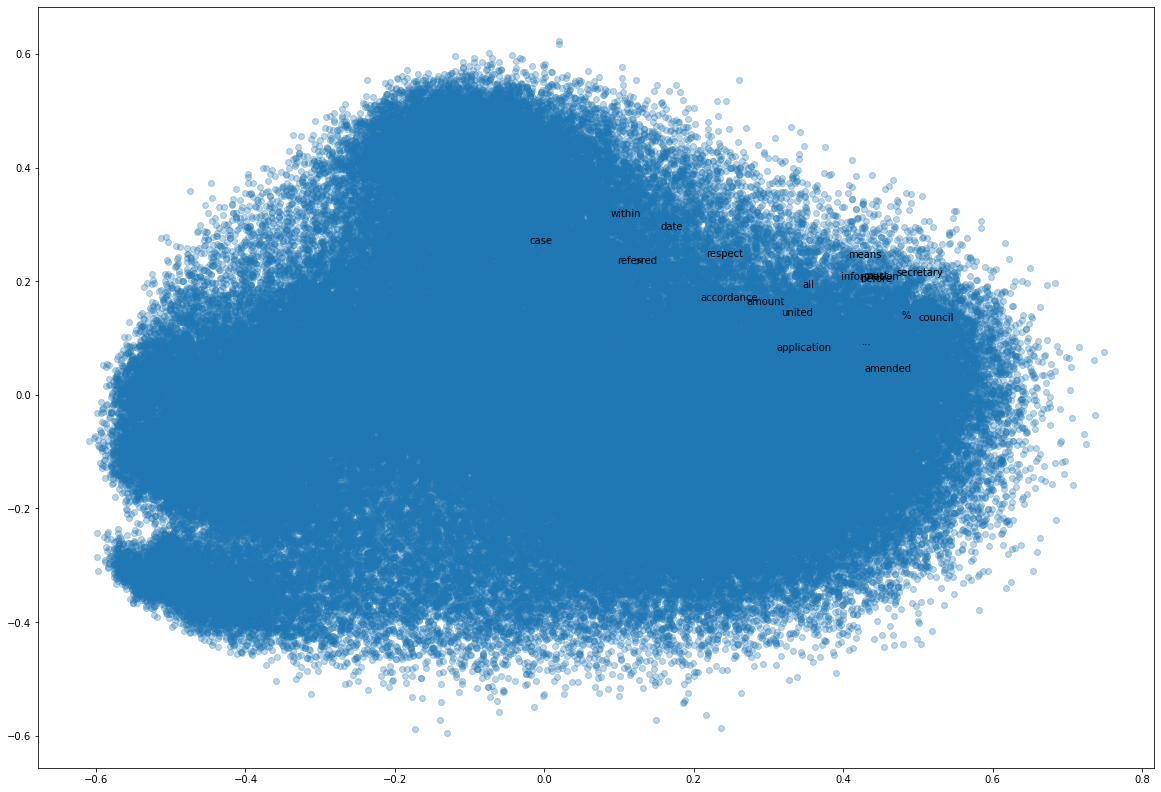

In [44]:
X = model_with_case_law[model_with_case_law.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection

plt.figure(figsize=(20,14))
plt.scatter(result[:, 0], result[:, 1], alpha = 0.3)
words = list(model_with_case_law.wv.vocab)[100:120]
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

## Step4: Prediction of Citation using Word2Vec

[Return to top](#Notebook-contents)

based on Similarity between Docs, we did prediction for a sample of docs.

Here is a sample of looking into distance between docs, using the `model_with_case_law` word2vec word embedding we built in the previous section.

In [45]:
s1 = opinions_df["text"][0]
s2 = opinions_df["text"][1]

#calculate distance between two opinions using WMD algorithm
distance = model_with_case_law.wmdistance(s1, s2)
print ('distance between the first and second cases in data set = %.3f' % distance)

# take a peek of distance between two case law
model_with_case_law.wmdistance(train_data.text.values[0], test_data.text.values[0])

distance between the first and second cases in data set = 0.033


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  if __name__ == '__main__':


0.04518008430204297

Next, we write function to interactively search for most matched document for a current case with the most close distance, and print our its `min_distance`, `most_matched_case_idx`.

In [46]:
# search for the most similar case in training dataset
def most_similar_case(curr_case, case_lst):
    most_matched_case_idx = -1
    min_distance = None
    for i in range(len(case_lst)):
        distance = model_with_case_law.wmdistance(case_lst[i], curr_case)
        if min_distance is None or distance < min_distance:
            min_distance = distance
            most_matched_case_idx = i
    return min_distance, most_matched_case_idx


Here is a accuracy metrics defined to look at how many correct predictions are there in both list.

In [47]:
def accuracy(pred_cite_lst, real_cite_lst):
    def _intersection(lst1, lst2):
        return list(set(lst1) & set(lst2))
    def _union(lst1, lst2):
        return list(set(lst1 + lst2))
    return len(_intersection(pred_cite_lst,real_cite_lst))/len(_union(pred_cite_lst,real_cite_lst))

Next, we try to predict for one example in test data.

In [48]:
def prediction(curr_case):
    min_distance, most_matched_case_idx = most_similar_case(curr_case, train_data.text.values[:100])
    print("Min Distance is " + str(min_distance))
    print("The case that matches most with current case is "+ str(most_matched_case_idx))

    # take a look at the prediction result 
    # citation list from the most similar case
    pred_lst = train_data['cites_list'].values[most_matched_case_idx]
    actual_lst = test_data['cites_list'].values[0]

    print("predicted citation")
    print(pred_lst)
    # the true citation list for this test case.
    print("actual citation")
    print(actual_lst)
    print("accuracy")
    print(accuracy(pred_lst, actual_lst))
    print("============================")

In [49]:
# find the case with minimal distance with one example case in test data
# searching list is cutted down as a subset of training data, 
# in order to reduce time
curr_case_lst = test_data.text.values[:20]

for case in curr_case_lst:
    prediction(case)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  


Min Distance is 0.031517908074979666
The case that matches most with current case is 18
predicted citation
['30 L.Ed. 2d at 433', '92 S.Ct. at 499', '357 A. 2', '434 U.S. 893', '417 U.S. 933', '235 N.W. 2d 581', '395 Mich. 306', '262 N.W. 2d at 895', '262 N.W. 2d 890', '79 Mich. App. 714', '322 A. 2d 564', '22 Md. App. 165', '277 Md. 687', '279 N.W. 2d 9', '374 A. 2d 816', '594 F. 2d at 18', '242 S.E. 2d 704', '454 F. 2d 426', '500 F. 2d 375', '518 F. 2d 1173', '404 U.S. at 262', '594 F. 2d 12', '30 L.Ed. 2d 427', '92 S.Ct. 495', '404 U.S. 257', '260 S.E. 2d 650', '44 N.C. App. 141']
actual citation
['95 L. Ed. 2d 697', '652 A.2d 874', '518 S.E.2d at 215', '490 S.E.2d 569', '127 N.C. App. 426', '508 S.E.2d. 277', '349 N.C. 483', '60 L. Ed. 2d 447', '441 U.S. 520', '481 U.S. 739', '19 Cal. Rptr. 2d 390', '829 P.2d 1096', '986 S.W.2d 486', '734 A.2d 684', '561 N.E.2d 643', '927 F.2d 185', '954 F.2d 386', '955 F.2d 592', '441 N.W.2d 247', '657 N.E.2d 602', '896 P.2d 346', '627 So. 2d 1', 

> As we could see from the sample of prediction result above, we could compare the list of actual citation cases list, and the list of predicted citation list, and check how many intersections are there, namely correct prediction.

> We divided the number of correct prediction by the total number of cases appeared in the union of both lists, and produced of accuracy score.

> It turns out all samples of prediction gives an accuracy of 0, meaning there's none of the citations in the prediction list actually appeared in actual prediction list. 

> It somehow makes sense, as in this model, we are using the most similar/closest document’s citation list as our prediction result. The model focuses on word embedding using word2vec, and it just helps us to define the distance between documents, but doesn't help in adding the complexity of model to produce citation result. Thus, the Accuracy Result not promising, so we move on to explore other models with NN and more advanced techniques.

In [50]:
train_data = opinions_df[opinions_df["decision_date"] <= 1990]
test_data = opinions_df[opinions_df["decision_date"] > 1990]

In [51]:
train_data.shape

(6457, 10)

In [52]:
test_data.shape

(1173, 10)

## Explore: Clustering based on header information

[Return to top](#Notebook-contents)

> When handling our case law data, we notice that the data could be divided by the parts of header and opinion. Header contains some keywords including the names of judges, decision date, court, author and type. In this part, we aim to explore whether information in header could provide useful information for our model of predicting the citations. If so, we would combine these key words with our opinion in the further modeling.

In [53]:
train_data_mod = train_data.copy()
train_data_mod[["name_1", "name_2"]] = train_data_mod["name"].str.split(' v. ', expand=True)[[0, 1]]

> To perform clustering, we need to treat those variables as categorical variables and perform preprocessing on these text information.

In [54]:
selected_cols = ["name_1", "name_2", "decision_date", "court", "author", "type"]
train_data_mod = train_data_mod[selected_cols]
to_dummy = ["court", "type"]
factorize = ["name_1", "name_2", "author"]

for var in factorize:
    train_data_mod[var] = pd.factorize(train_data_mod[var])[0] + 1

for var in to_dummy:
    curr_df = pd.get_dummies(train_data_mod[var], drop_first=True)
    train_data_mod = train_data_mod.drop([var], axis=1)
    train_data_mod = pd.concat([train_data_mod, curr_df], axis=1)

In [55]:
train_data_mod.shape

(6457, 10)

In [56]:
def plot_clusters(full_data, group_col):
    
    # seperate features only from cluster labels
    feature_columns = [colname for colname in list(full_data.columns) if 'Cluster' not in colname]
    features_only = full_data[feature_columns]

    # fit PCA to the whole data
    fitted_pca = PCA().fit(features_only)

    # take a sample of the whole data
    df_sample = features_only.sample(2000, random_state=109)

    # apply the PCA transform on the sample
    pca_sample = pd.DataFrame(fitted_pca.transform(df_sample), columns = ["PCA{}".format(i) for i in range(len(df_sample.columns.values))])
    pca_sample.index = df_sample.index
    
    # re-include a cluster label for the pca data
    pca_sample[group_col] = full_data.loc[pca_sample.index, group_col]
    
    plt.figure(figsize=(11,8.5))
    marker_types = [".", "v", "1", "^", "s", "p", "P", "3", "H", "<", "|", "_", "x", "*","d","X"]
    marker_colors = np.concatenate([np.array(plt.cm.tab10.colors),np.array(plt.cm.Pastel1.colors)])
    
    for i, (cluster_id, cur_df) in enumerate(pca_sample.groupby([group_col])):

        pca1_scores = cur_df.iloc[:,0]
        pca2_scores = cur_df.iloc[:,1]
        plt.scatter(pca1_scores, pca2_scores, label=cluster_id, c=marker_colors[i].reshape(1,-1), marker=marker_types[i])

    plt.xlabel("PC1 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[0],1)))
    plt.ylabel("PC2 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[1],1)))
    plt.legend()
    plt.show()
    return pca_sample

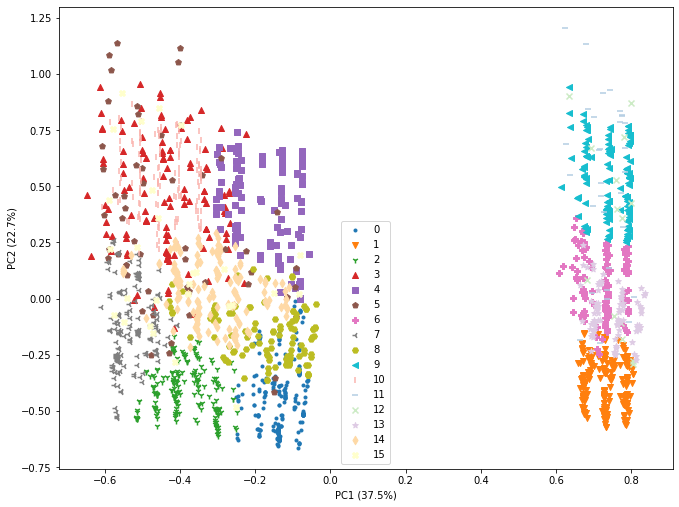

PCA0      PCA1      PCA2  ...      PCA8      PCA9  Cluster16
6313 -0.115868  0.301325 -0.243774  ...  0.000342 -0.000248          4
5689 -0.089246  0.558865 -0.293047  ...  0.000096 -0.000099          4
4773  0.681547 -0.532353  0.056716  ... -0.000070  0.000223          1
3571  0.731837  0.217631 -0.111781  ... -0.000624  0.000102          6
727   0.674104 -0.373043  0.053761  ... -0.000420  0.000369          1
...        ...       ...       ...  ...       ...       ...        ...
856  -0.351812 -0.410095 -0.030673  ...  0.000408 -0.000157          2
2612  0.753163 -0.309247 -0.012711  ... -0.000073  0.000122          1
1838 -0.360549 -0.316248 -0.054062  ...  0.000345 -0.000180          2
3288 -0.406380  0.024023 -0.103237  ... -0.000125 -0.000286         14
3870 -0.115585 -0.256046 -0.100776  ...  0.000653  0.000037          8

[2000 rows x 11 columns]

In [57]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN

scaler = MinMaxScaler()
scaler.fit(train_data_mod)
df_process = scaler.transform(train_data_mod)
df_process = pd.DataFrame(df_process, columns = train_data_mod.columns)

km16 = KMeans(n_clusters=16, n_init=46, random_state=109).fit(df_process)
df_process['Cluster16'] = km16.labels_

plot_clusters(df_process, 'Cluster16')

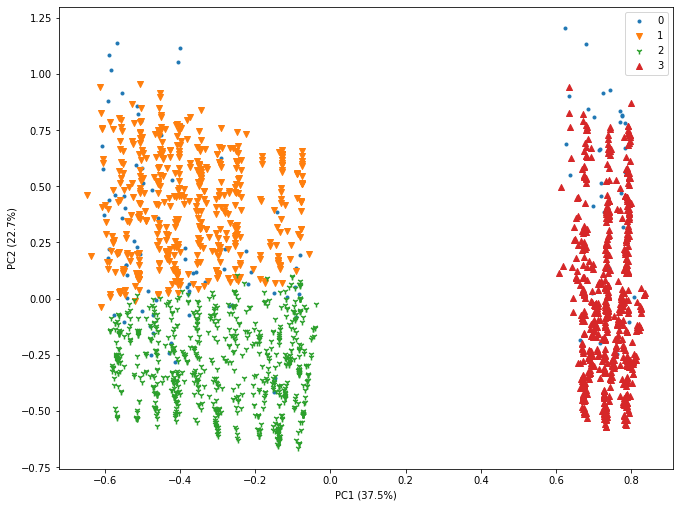

PCA0      PCA1      PCA2  ...      PCA8      PCA9  Cluster4
6313 -0.115868  0.301325 -0.243774  ...  0.000342 -0.000248         1
5689 -0.089246  0.558865 -0.293047  ...  0.000096 -0.000099         1
4773  0.681547 -0.532353  0.056716  ... -0.000070  0.000223         3
3571  0.731837  0.217631 -0.111781  ... -0.000624  0.000102         3
727   0.674104 -0.373043  0.053761  ... -0.000420  0.000369         3
...        ...       ...       ...  ...       ...       ...       ...
856  -0.351812 -0.410095 -0.030673  ...  0.000408 -0.000157         2
2612  0.753163 -0.309247 -0.012711  ... -0.000073  0.000122         3
1838 -0.360549 -0.316248 -0.054062  ...  0.000345 -0.000180         2
3288 -0.406380  0.024023 -0.103237  ... -0.000125 -0.000286         1
3870 -0.115585 -0.256046 -0.100776  ...  0.000653  0.000037         2

[2000 rows x 11 columns]

In [58]:
scaler = MinMaxScaler()
scaler.fit(train_data_mod)
df_process = scaler.transform(train_data_mod)
df_process = pd.DataFrame(df_process, columns = train_data_mod.columns)

km4= KMeans(n_clusters=4, n_init=46, random_state=109).fit(df_process)
df_process['Cluster4'] = km4.labels_

plot_clusters(df_process, 'Cluster4')

> Based on the visualization plot, we can see both 16 clusters and 4 clusters provide some useful information for clustering. When we use 4 clusters, there exist clear boundary of three clusters. When we use 16 clusters, we also observe distinct boundary among several clusters. Thus, we decide to incorporate these information in our analysis.

## Model: BERT for text classification

[Return to top](#Notebook-contents)

> In this part, we implement a naive model which treats each citations in the citing list in training dataset as a category for classification. And we essentially run classification model with multiple labels. Since there are 42534 different citations in training dataset, and we are not able to predict something that's not in our training dataset. So we, in total, have 42534 different categories. As we can see, this representation has many disadvantages. Firstly, it is really spase. Second, this might result in inaccurate prediction, since one case might have multiple citations and the length of the citation varies a lot among different cases. It's hard to get accurate prediction from the model. Moreover, we need lots of memory storage to complete the training and testing. During our training process, sometimes we even run out of our memory in Google Colab Pro. And our experiment validates our idea. The results from this model is very inaccurate, giving nearly the same prediction for all text cases even if we have run 20 epochs and train for 1 hours using GPU.

> Motiveted by previous analysis, we firstly combine the information in header with the information in opinion and we will use the combined text for further modeling.

In [59]:
opinions_df.fillna(" ", inplace=True)
# intuition behind incorporating text with header
# although header is short, it contains some high-quality information
# insert those information at the beginning of our text
opinions_df['text'] = opinions_df[['name', 'court', 'author', 'type', 'text']].agg('.'.join, axis=1)

> Then we split the validation data from train data for further fine-tuning the paramters in BERT model. 

In [60]:
train_data = opinions_df[opinions_df["decision_date"] < 1990]
val_data = opinions_df[opinions_df["decision_date"] == 1990]
test_data = opinions_df[opinions_df["decision_date"] > 1990]

> Then we get the total amount of citations in our training dataset, and treat them as the categories for our classification task.

In [61]:
total_citations = []
for i in train_data.index:
    total_citations.extend(train_data.loc[i, "cites_list"])
    # for element in train_data.loc[i, "citation"]:
    #     total_citations.append(element["cite"])
total_citations = list(set(total_citations))

In [62]:
y_pred_train = np.zeros((train_data.shape[0], len(total_citations)))
for i in range(len(train_data.index)):
    curr_list = train_data.loc[train_data.index[i], "cites_list"]
    for element in curr_list:
        y_pred_train[i, total_citations.index(element)] = 1

In [63]:
# see how many rows in documentation whose citations are all not in the training dataset
# this means the accuracy is always 0 for this rows
# because we essentially can't predict something that's not in our y labels
count_zeros_acc = []
y_pred_val = np.zeros((val_data.shape[0], len(total_citations)))
for i in range(len(val_data.index)):
    curr_list = val_data.loc[val_data.index[i], "cites_list"]
    num = 0
    for j in range(len(curr_list)):
        if num == len(curr_list) - 1 and curr_list[j] not in total_citations:
            count_zeros_acc.append(i)
        elif curr_list[j] not in total_citations:
            num += 1
        else:
            y_pred_val[i, total_citations.index(element)] = 1

In [64]:
print("There are " + str(round(len(count_zeros_acc) / val_data.shape[0] * 100, 2)) + "% rows in validation data whose citation lists are all not in training dataset. ")

There are 51.24% rows in validation data whose citation lists are all not in training dataset. 


In [65]:
count_zeros_acc = []
y_pred_test = np.zeros((test_data.shape[0], len(total_citations)))
for i in range(len(test_data.index)):
    curr_list = test_data.loc[test_data.index[i], "cites_list"]
    num = 0
    for j in range(len(curr_list)):
        if num == len(curr_list) - 1 and curr_list[j] not in total_citations:
            count_zeros_acc.append(i)
        elif curr_list[j] not in total_citations:
            num += 1
        else:
            y_pred_test[i, total_citations.index(element)] = 1

In [66]:
print("There are " + str(round(len(count_zeros_acc) / test_data.shape[0] * 100, 2)) + "% rows in testing data whose citation lists are all not in training dataset. ")

There are 52.43% rows in testing data whose citation lists are all not in training dataset. 


In [67]:
!pip3 install transformers==4.4.1

     |████████████████████████████████| 2.1MB 7.6MB/s 
     |████████████████████████████████| 901kB 36.9MB/s 
     |████████████████████████████████| 3.3MB 49.9MB/s 


In [68]:
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [69]:
import tensorflow as tf

train_x = train_data['text'].values
validate_x = val_data['text'].values
test_x = test_data['text'].values

In [70]:
sequence_length = 256

# Train
train_x_processed = tokenizer.batch_encode_plus(
        train_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

In [71]:
validate_x_processed = tokenizer.batch_encode_plus(
        validate_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

In [72]:
test_x_processed = tokenizer.batch_encode_plus(
        test_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

In [73]:
batch_size = 32
num_classes = len(total_citations)
TRAIN_SHUFFLE_BUFFER_SIZE = len(train_x)
VALIDATION_SHUFFLE_BUFFER_SIZE = len(validate_x)

In [74]:
train_data = tf.data.Dataset.from_tensor_slices(((train_x_processed["input_ids"],
                                                  train_x_processed["token_type_ids"],
                                                  train_x_processed["attention_mask"]), y_pred_train))
validation_data = tf.data.Dataset.from_tensor_slices(((validate_x_processed["input_ids"],
                                                  validate_x_processed["token_type_ids"],
                                                  validate_x_processed["attention_mask"]), y_pred_val))

In [75]:
test_data = tf.data.Dataset.from_tensor_slices(((test_x_processed["input_ids"],
                                                  test_x_processed["token_type_ids"],
                                                  test_x_processed["attention_mask"]), y_pred_test))

In [76]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

##################
# Validation data
##################
validation_data = validation_data.shuffle(buffer_size=VALIDATION_SHUFFLE_BUFFER_SIZE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: (((None, 256), (None, 256), (None, 256)), (None, 42534)), types: ((tf.int32, tf.int32, tf.int32), tf.float64)>
validation_data <PrefetchDataset shapes: (((None, 256), (None, 256), (None, 256)), (None, 42534)), types: ((tf.int32, tf.int32, tf.int32), tf.float64)>


In [77]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  32708646  
Total params: 142,190,886
Trainable params: 142,190,886
Non-trainable params: 0
_________________________________________________________________


In [79]:
import time
from tensorflow.python.keras import backend as K
from tensorflow import keras

K.clear_session()

learning_rate = 2e-5
epochs = 20

optimizer = keras.optimizers.Adam(lr=learning_rate, epsilon=1e-08)
# Loss
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# We also try the sparse_categorical_crossentropy but it doesn't work
# one law case can be matched to multiple classes
#model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train model

start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autog

In [80]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import json
from tensorflow.python.keras.utils.layer_utils import count_params

def save_model(model, path="models",model_name="model01"):

    # Ensure path exists
    if not os.path.exists(path):
        os.mkdir(path)

    if isinstance(model,TFBertForSequenceClassification):
      #model.save_pretrained(path)
      model.save_weights(os.path.join(path,model_name+".h5"))
    else:
      # Save the enitire model (structure + weights)
      model.save(os.path.join(path,model_name+".hdf5"))

      # Save only the weights
      model.save_weights(os.path.join(path,model_name+".h5"))

      # Save the structure only
      model_json = model.to_json()
      with open(os.path.join(path,model_name+".json"), "w") as json_file:
          json_file.write(model_json)

def get_model_size(path="models",model_name="model01"):
    model_size = os.stat(os.path.join(path,model_name+".h5")).st_size
    return model_size

class JsonEncoder(json.JSONEncoder):
    def default(self, obj):
      if isinstance(obj, np.integer):
          return int(obj)
      elif isinstance(obj, np.floating):
          return float(obj)
      elif isinstance(obj, decimal.Decimal):
          return float(obj)
      elif isinstance(obj, np.ndarray):
          return obj.tolist()
      else:
          return super(JsonEncoder, self).default(obj)

def evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, epochs,save=True):
    
    # Get the model train history
    model_train_history = training_results.history
    # Get the number of epochs the training was run for
    num_epochs = len(model_train_history["loss"])

    # Plot training results
    fig = plt.figure(figsize=(20,5))
    axs = fig.add_subplot(1,3,1)
    axs.set_title('Loss')
    # Plot all metrics
    for metric in ["loss","val_loss"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()
    
    axs = fig.add_subplot(1,3,2)
    axs.set_title('Accuracy')
    # Plot all metrics
    for metric in ["accuracy","val_accuracy"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()

    plt.show()
    
    # Evaluate on test data
    evaluation_results = model.evaluate(test_data)
    print(evaluation_results)
    
    if save:
        # Save model
        save_model(model, model_name=model.name)
        model_size = get_model_size(model_name=model.name)

        # Save model history
        with open(os.path.join("models",model.name+"_train_history.json"), "w") as json_file:
            json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

        trainable_parameters = count_params(model.trainable_weights)
        non_trainable_parameters = count_params(model.non_trainable_weights)

        # Save model metrics
        metrics ={
            "trainable_parameters":trainable_parameters,
            "execution_time":execution_time,
            "loss":evaluation_results[0],
            "accuracy":evaluation_results[1],
            "model_size":model_size,
            "learning_rate":learning_rate,
            "epochs":epochs,
            "name": model.name,
            "id": int(time.time())
        }
        with open(os.path.join("models",model.name+"_metrics.json"), "w") as json_file:
            json_file.write(json.dumps(metrics,cls=JsonEncoder))

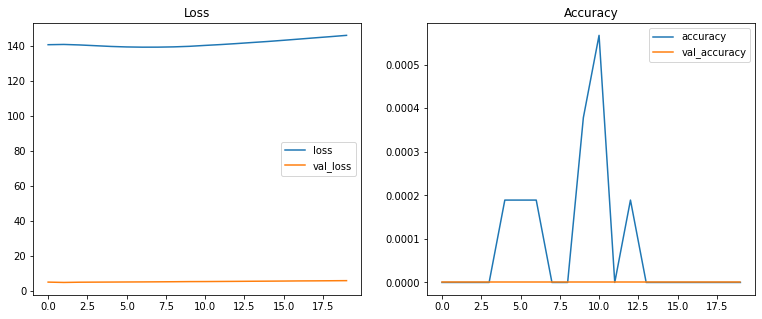

37/37 [==============================] - 12s 322ms/step - loss: 6.0055 - accuracy: 0.0000e+00
[6.00553035736084, 0.0]


In [81]:
evaluate_save_model(model, validation_data, training_results, execution_time, learning_rate, epochs)

In [82]:
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [83]:
model.evaluate(test_data)

37/37 [==============================] - 12s 323ms/step - loss: 5.4745 - accuracy: 0.0000e+00


[5.474530220031738, 0.0]

In [84]:
y_pred_bert = model.predict(test_data)

In [85]:
y_pred_bert["logits"].shape

(1173, 42534)

In [86]:
logits = tf.nn.softmax(y_pred_bert["logits"])
y_preds = np.argmax(y_pred_bert['logits'], axis=1)

In [87]:
logits

<tf.Tensor: shape=(1173, 42534), dtype=float32, numpy=
array([[2.6052330e-06, 2.7806275e-06, 1.8610142e-05, ..., 1.7595196e-06,
        2.0213356e-06, 3.1264568e-05],
       [2.6052339e-06, 2.7806273e-06, 1.8610141e-05, ..., 1.7595194e-06,
        2.0213354e-06, 3.1264553e-05],
       [2.6052328e-06, 2.7806273e-06, 1.8610150e-05, ..., 1.7595194e-06,
        2.0213354e-06, 3.1264568e-05],
       ...,
       [2.6052328e-06, 2.7806273e-06, 1.8610150e-05, ..., 1.7595194e-06,
        2.0213354e-06, 3.1264553e-05],
       [2.6054349e-06, 2.7808601e-06, 1.8611910e-05, ..., 1.7596885e-06,
        2.0215643e-06, 3.1266947e-05],
       [2.6052342e-06, 2.7806277e-06, 1.8610150e-05, ..., 1.7595194e-06,
        2.0213354e-06, 3.1264539e-05]], dtype=float32)>

> From the results above, we can see that the predicted results are very similar to each other. Our model doesn't classfy them correctly. Besides, the validation accuracy sticks to 0 during the training process. This shows that simply treating them as text classification problem would run into trouble. We need to use a better representation.

## Model: BERT for Document Similarity

[Return to top](#Notebook-contents)

> In this part, we experiment a BERT model for calculating document similarity. The architecture is described through the plot in below. 

> We first conduct preprocessing of our data. Then we get the context embedding through implementing bert-base-nli-mean-tokens model from the sentence-transformers-repository. The sentence-transformers repository allows to train and use Transformer models for generating sentence and text embeddings. The model is described in the paper Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks (https://arxiv.org/abs/1908.10084).

> After we get the context embedding of training and testing dataset, we calculate the pairwise similarity between each case in testing dataset and each case in training dataset. We use both the Cosine similarity and Euclidean similarity. Our prediction is based on the assumption that similar documentation would have similar citations. So for a given case in testing dataset, we would use the citation lists from the most similar cases in training dataset as the predicted citations for the given case.

> However, we have several concerns on the model. Firstly, the assumption is naive and might not be valid. It's possible that two different documents might have same citations and two similar documents have totally different citations. Secondly, it has low accuracy as we can see from the output above, if we use the citation list from the top 1 similar case as our prediction, the accuracy is 3.41%. If we use the citation list from the top 2 similar cases as our prediction, the accuracy is 5.71%. if we use the citation list from the top 3 similar cases as our prediction, the accuracy is 7.33%. The accuracy score is low. Moreover, when we use the number of the most similar cases, we essentially increase our the number of citations of our prediction. Even if our model is terrible, like a randomly-generated one, we might result in increased accuracy. Finally, this models has many limitations to be applicable. For instance, it's hard for us to decide how many top cases we should use. Besides, we could not differentiate between different citations for a given training case. And whenever we desire to decide the citation, we need to compare the pairwise similarity for all training case, which results in high computational cost.

> Although simply using the similarity score for deciding the citation might not be useful and applicable, we could utilize the information from the context embedding from SentenceBERT model to create a better model to capture the relationship of citation. 

<div>
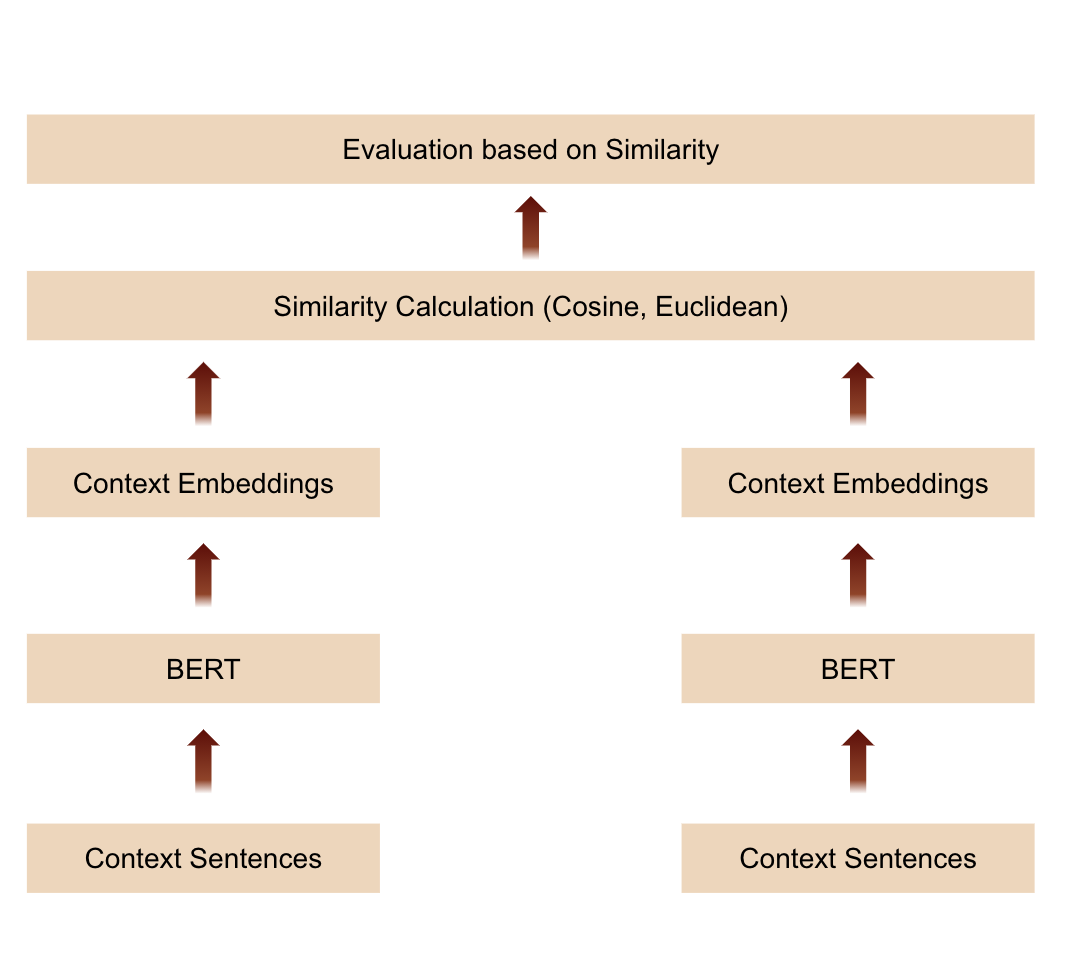
</div>

In [88]:
train_data = opinions_df[opinions_df["decision_date"] <= 1990]
test_data = opinions_df[opinions_df["decision_date"] > 1990]

In [89]:
!pip install sentence_transformers

In [90]:
from sentence_transformers import SentenceTransformer

In [91]:
from tensorflow.keras.optimizers import Adam
import tensorflow
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, \
                            TimeDistributed, GRU, Dropout, Bidirectional, \
                            Conv1D, BatchNormalization
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

In [92]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [93]:
import nltk
from nltk.tokenize import RegexpTokenizer

train_data_mod = train_data.copy()

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
# Tokenize text using nltk's word tokenizer, removing all punctuations
tokenizer = RegexpTokenizer(r'\w+')

for i in train_data_mod.index:
    words = tokenizer.tokenize(train_data_mod.loc[i, "text"])
    # Remove stop words
    all_words = [w.lower() for w in words if w.lower() not in stop_words]
    train_data_mod.loc[i, "text"] = " ".join(all_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [94]:
test_data_mod = test_data.copy()

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
# Tokenize text using nltk's word tokenizer, removing all punctuations
tokenizer = RegexpTokenizer(r'\w+')

for i in test_data_mod.index:
    words = tokenizer.tokenize(test_data_mod.loc[i, "text"])
    # Remove stop words
    all_words = [w.lower() for w in words if w.lower() not in stop_words]
    test_data_mod.loc[i, "text"] = " ".join(all_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
# from transformers import AutoTokenizer, AutoModel
# import torch


# #Mean Pooling - Take attention mask into account for correct averaging
# def mean_pooling(model_output, attention_mask):
#     token_embeddings = model_output[0] #First element of model_output contains all token embeddings
#     input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#     sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
#     sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
#     return sum_embeddings / sum_mask



# #Sentences we want sentence embeddings for
# sentences = ['This framework generates embeddings for each input sentence',
#              'Sentences are passed as a list of string.',
#              'The quick brown fox jumps over the lazy dog.']

# #Load AutoModel from huggingface model repository
# tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")
# model = AutoModel.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")

# #Tokenize sentences
# encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors='pt')

# #Compute token embeddings
# with torch.no_grad():
#     model_output = model(**encoded_input)

# #Perform pooling. In this case, mean pooling
# sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

> Reference: https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens

> We could use this model more convinient when having sentence-transformers installed; use model.encode to subsititute the above code.

In [96]:
document_embeddings = sbert_model.encode(train_data_mod['text'].values)

In [97]:
document_embeddings.shape

(6457, 768)

In [98]:
document_embeddings_test = sbert_model.encode(test_data_mod['text'].values)

In [99]:
document_embeddings_test.shape

(1173, 768)

In [100]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

In [101]:
cos_results = []
euclid_results = []
for i in range(document_embeddings_test.shape[0]):
    pairwise_similarities = cosine_similarity(document_embeddings, document_embeddings_test[i:i+1, :])
    similar_ix = np.argsort(pairwise_similarities.flatten())[::-1]
    cos_results.append(similar_ix)
    pairwise_differences = euclidean_distances(document_embeddings, document_embeddings_test[i:i+1, :])
    similar_ix = np.argsort(pairwise_differences.flatten())
    euclid_results.append(similar_ix)

In [102]:
# if only using the top 1 similarity as our prediction
scores = []
count = 0
for i in range(document_embeddings_test.shape[0]):
    score = 0
    for element in test_data_mod["cites_list"].values[i]:
        if element in train_data_mod["cites_list"].values[cos_results[i][0]] or element in train_data_mod["cites_list"].values[euclid_results[i][0]]:
            score += 1
    scores.append(score)
    if score > 0:
        count += 1
print(count / len(scores))

0.03410059676044331


In [103]:
# if only using the top 2 similarity as our prediction
scores = []
count = 0
for i in range(document_embeddings_test.shape[0]):
    score = 0
    for element in test_data_mod["cites_list"].values[i]:
        if element in train_data_mod["cites_list"].values[cos_results[i][0]] or element in train_data_mod["cites_list"].values[euclid_results[i][0]] or \
        element in train_data_mod["cites_list"].values[cos_results[i][1]] or element in train_data_mod["cites_list"].values[euclid_results[i][1]]:
            score += 1
    scores.append(score)
    if score > 0:
        count += 1
print(count / len(scores))

0.05711849957374254


In [104]:
# if only using the top 3 similarity as our prediction
scores = []
count = 0
for i in range(document_embeddings_test.shape[0]):
    score = 0
    for element in test_data_mod["cites_list"].values[i]:
        if element in train_data_mod["cites_list"].values[cos_results[i][0]] or element in train_data_mod["cites_list"].values[euclid_results[i][0]] or \
        element in train_data_mod["cites_list"].values[cos_results[i][1]] or element in train_data_mod["cites_list"].values[euclid_results[i][1]] or \
        element in train_data_mod["cites_list"].values[cos_results[i][2]] or element in train_data_mod["cites_list"].values[euclid_results[i][2]]:
            score += 1
            # print(train_data_mod["cites_list"].values[cos_results[i][0]])
            # print(test_data_mod["cites_list"].values[i])
    scores.append(score)
    if score > 0:
        count += 1
    # print(train_data_mod["citation"].values[cos_results[i][0]])
    # print(train_data_mod["cites_list"].values[cos_results[i][0]])
    # print(train_data_mod["citation"].values[euclid_results[i][0]])
    # print(train_data_mod["cites_list"].values[cos_results[i][0]])
print(count / len(scores))

0.0733162830349531


## Model: Our Proposed Model - LawPairBERT Model with BERT Embedding

[Return to top](#Notebook-contents)

> We creatively design a better, efficient, and accurate representation for predicting whether one law case is the citation of another one. And we call it LawPairBERT Model. It has 2 versions, one is just using BERT Embedding and another one uses both BERT Embedding and Graph Embedding.

> Our model has several advantages: 1. It directly captures the citation relationship among each pair of law cases, instead of using similarity score; 2. It achieves high accuracy in predicting both true and false condition of citation, well above our previous models; 3. Through our designed method - Imbalanced Random Concatenation, we successfully reduce the computational cost while remaining high accuracy; 4. It's flexible and 

> In this part, we focus on the first version of our LawPairBERT Model, which using BERT Embedding. The plot below shows the architecture of our model. We use the same context embeddings as calculated before in SentenceBERT model. However, instead of calculating similarity, we designed a pairs representation. After that, we implement neural network models to predict the probability of citations.

<div>
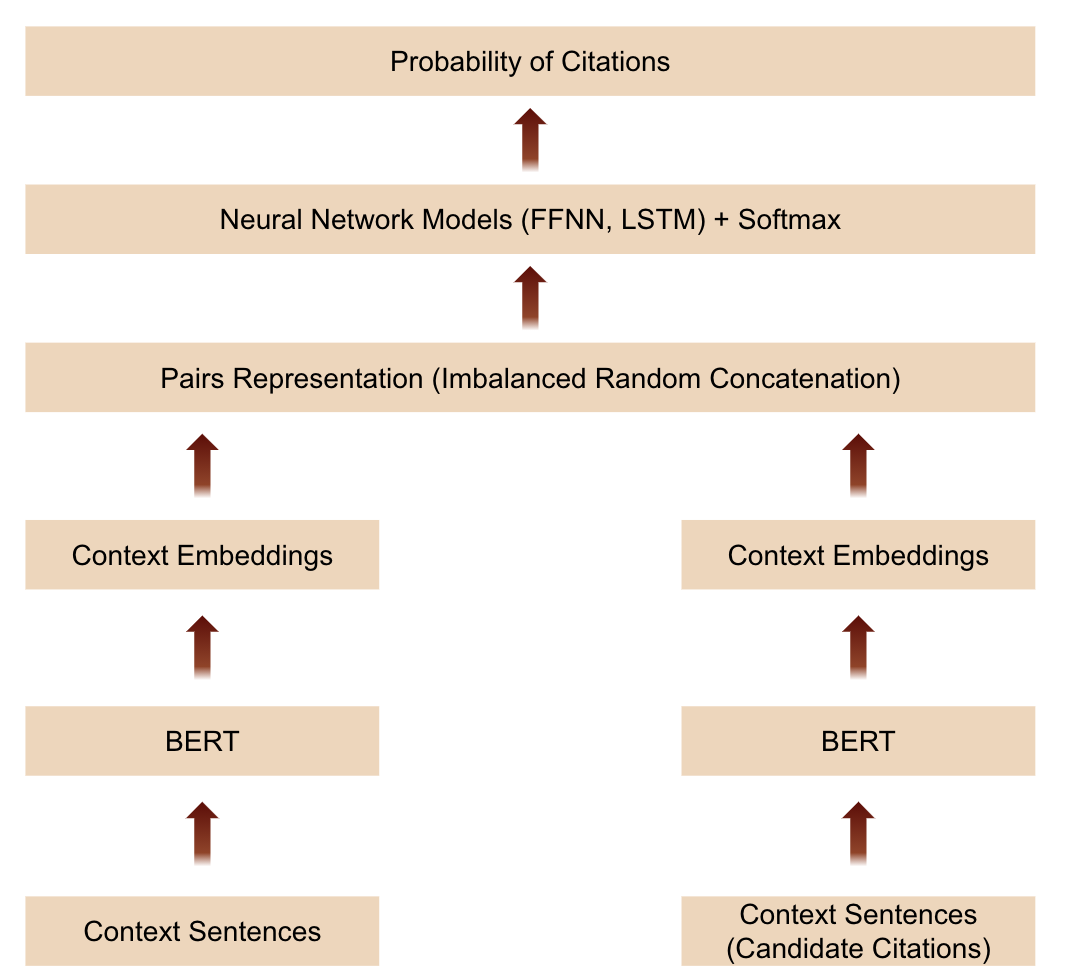
</div>

> The intuition behind our representation is to capture the citation relationship among any pairs of cases. And we could concatenate two embeddings from two different cases. In order to determine whether the second case is the citation of the first, we could give label 1 to those with citation relationship, and label 0 to those without citation.

> However, one big issue with this intuition is the size of pairs. Since we have 6457 cases in training data and 768 dimensions of embeddings, if we need to create all pairs representation, we will result in a big shape. Moreover, it’s quite imbalanced between label 1 and label 0 because the majority of the pairs are not citation relationship.

> We then creatively design Imbalanced Random Concatenation method to overcome this issue. We Include all pairs with citation relationship (label 1) and randomly select pairs without citation relationship (label 0). We would choose equally among all training data to ensure representativeness and variety.

<div>
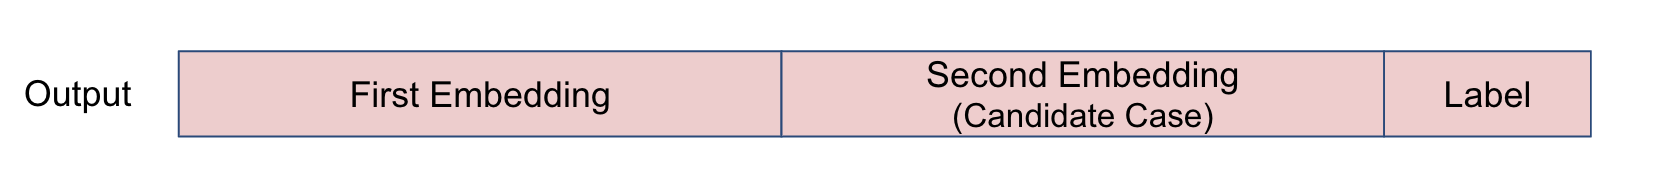
</div>

> For the part of neural network models, we mainly try FFNN and LSTM models. To deal with the imbalanced classification and improve accuracy of predicting citations correctly, we use recall in FFNN model for early stopping.

In [105]:
train_citations = []
for i in range(train_data_mod.shape[0]):
    citation_lst = train_data_mod["citation"].values[i]
    train_citations.append(citation_lst[0]["cite"])

> Implement Imbalanced Random Concatenation.

In [106]:
> Implement Imbalanced Random Concatenation.# self-defined machine learning model to learn the representation from the embedding results
results_temp = []
y_train_score = []
for i in range(document_embeddings.shape[0]):
    for element in train_data_mod["cites_list"].values[i]:
        if element in train_citations:
            index_citate = train_citations.index(element)
            curr_arr = np.concatenate((document_embeddings[i, :], document_embeddings[index_citate, :])).reshape((document_embeddings.shape[1]*2, 1))
            results_temp.append(curr_arr)
            y_train_score.append(1)

In [107]:
results_false = []
for i in range(document_embeddings.shape[0]):
    if len(y_train_score) >= 15000:
        break
    lst = np.random.choice(document_embeddings.shape[0], 3)
    for j in lst:
        element = train_data_mod["citation"].values[j][0]["cite"]
        if j != i and element not in train_data_mod["cites_list"].values[i] and element in train_citations:
            index_citate = train_citations.index(element)
            curr_arr = np.concatenate((document_embeddings[i, :], document_embeddings[index_citate, :])).reshape((document_embeddings.shape[1]*2, 1))
            if not any(np.array_equal(np.around(curr_arr, 4), x) for x in results_false):
                results_false.append(np.around(curr_arr, 4))
                results_temp.append(curr_arr)
                y_train_score.append(0)

In [108]:
x_train_score = np.concatenate(results_temp, axis=1).T

In [109]:
y_train_score = np.array(y_train_score)

In [110]:
x_train_score, x_val_score, y_train_score, y_val_score = train_test_split(x_train_score, y_train_score, test_size=0.25)

### Method 1: FFNN

[Return to top](#Notebook-contents)

In [111]:
dropout_rate = 0.2
batch_size = 32
epochs = 200
verbose = 1

In [112]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=50, verbose=1, mode='max',
    baseline=None, restore_best_weights=False
)

model1 = Sequential([
    Dense(512, activation='relu', input_shape=(x_train_score.shape[1], )),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(rate=dropout_rate),
    Dense(32, activation= 'relu'),
    Dense(1, activation= 'sigmoid')])

In [113]:
optimizer = Adam(learning_rate=0.0001)
loss = "binary_crossentropy"
metrics = [tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
           tensorflow.keras.metrics.Precision(name='precision'),
           tensorflow.keras.metrics.Recall(name='recall')]
# Compile model
model1.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [114]:
history = model1.fit(x_train_score, y_train_score, batch_size=batch_size, epochs=epochs, 
                    verbose=verbose, validation_data=(x_val_score, y_val_score), callbacks=[callback])

Epoch 1/200
352/352 [==============================] - 4s 6ms/step - loss: 0.4506 - accuracy: 0.8239 - precision: 0.6242 - recall: 7.7830e-04 - val_loss: 0.4035 - val_accuracy: 0.8227 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
352/352 [==============================] - 1s 4ms/step - loss: 0.3906 - accuracy: 0.8299 - precision: 0.6111 - recall: 0.0288 - val_loss: 0.3585 - val_accuracy: 0.8400 - val_precision: 0.7070 - val_recall: 0.1669
Epoch 3/200
352/352 [==============================] - 1s 4ms/step - loss: 0.3430 - accuracy: 0.8474 - precision: 0.6532 - recall: 0.2276 - val_loss: 0.3480 - val_accuracy: 0.8467 - val_precision: 0.6490 - val_recall: 0.2947
Epoch 4/200
352/352 [==============================] - 1s 4ms/step - loss: 0.3074 - accuracy: 0.8620 - precision: 0.6500 - recall: 0.3830 - val_loss: 0.3388 - val_accuracy: 0.8536 - val_precision: 0.6218 - val_recall: 0.4451
Epoch 5/200
352/352 [==============================] - 1s 4ms/step - loss: 0.2848 - accu

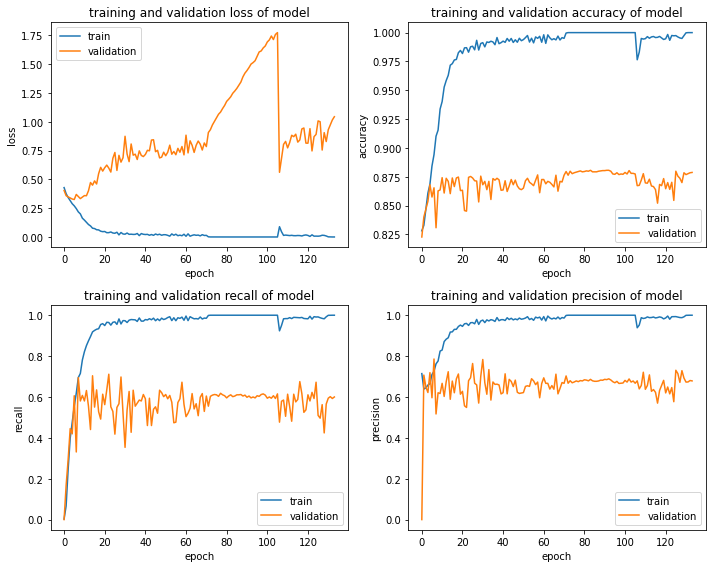

In [115]:
fig, ax = plt.subplots(2, 2, figsize = (10, 8))
ax = ax.ravel()
label = ["loss", "accuracy", "recall", "precision"]
for i in range(4):
    ax[i].plot(history.history[label[i]], label = "train")
    ax[i].plot(history.history['val_' + label[i]], label = "validation")
    ax[i].set_title('training and validation ' + label[i] + ' of model')
    ax[i].set_ylabel(label[i])
    ax[i].set_xlabel('epoch')
    ax[i].legend()

plt.tight_layout()

In [116]:
results_test_acc = []
y_test_score_acc = []
for i in range(document_embeddings_test.shape[0]):
    for element in test_data_mod["cites_list"].values[i]:
        if element in train_citations:
            index_citate = train_citations.index(element)
            curr_arr = np.concatenate((document_embeddings_test[i, :], document_embeddings[index_citate, :])).reshape((document_embeddings.shape[1]*2, 1))
            results_test_acc.append(curr_arr)
            y_test_score_acc.append(1)

x_test_score_acc = np.concatenate(results_test_acc, axis=1).T
y_test_score_acc = np.array(y_test_score_acc)
model1.evaluate(x_test_score_acc, y_test_score_acc)

21/21 [==============================] - 0s 3ms/step - loss: 6.4138 - accuracy: 0.4717 - precision: 1.0000 - recall: 0.4717


[6.413846015930176, 0.4717261791229248, 1.0, 0.4717261791229248]

> defined some evaluation functions for evaluating our accuracy

In [117]:
def evaluate_random_pairs(lst, model, lstm=False):
    for i in lst:
        results_test = []
        y_test_score = []
        for j in range(document_embeddings.shape[0]):
            element = train_data_mod["citation"].values[j][0]["cite"]
            if j != i and element not in test_data_mod["cites_list"].values[i] and element in train_citations:
                index_citate = train_citations.index(element)
                curr_arr = np.concatenate((document_embeddings[index_citate, :], document_embeddings_test[i, :])).reshape((document_embeddings.shape[1]*2, 1))
                results_test.append(curr_arr)
                y_test_score.append(0)
            elif j != i and element in test_data_mod["cites_list"].values[i] and element in train_citations:
                index_citate = train_citations.index(element)
                curr_arr = np.concatenate((document_embeddings[index_citate, :], document_embeddings_test[i, :])).reshape((document_embeddings.shape[1]*2, 1))
                results_test.append(curr_arr)
                y_test_score.append(1)
        x_test_score = np.concatenate(results_test, axis=1).T
        y_test_score = np.array(y_test_score)
        print("======== case " + str(i) + " ========")
        if lstm:
            x_test_score = np.reshape(np.array(x_test_score), (x_test_score.shape[0], 1, x_test_score.shape[1]))
        model.evaluate(x_test_score, y_test_score)
        y_pred = model.predict(x_test_score).round(0)
        y_actu = pd.Series(y_test_score, name='Actual')
        y_pred_df = pd.Series(y_pred.flatten(), name='Predicted')
        print(pd.crosstab(y_actu, y_pred_df))

In [118]:
lst = np.random.choice(document_embeddings_test.shape[0], 10)

In [119]:
evaluate_random_pairs(lst, model1)

======== case 957 ========
202/202 [==============================] - 1s 2ms/step - loss: 0.5141 - accuracy: 0.9312 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          6012  444
======== case 84 ========
202/202 [==============================] - 1s 2ms/step - loss: 0.2013 - accuracy: 0.9645 - precision: 0.0087 - recall: 1.0000
Predicted   0.0  1.0
Actual              
0          6225  229
1             0    2
======== case 549 ========
202/202 [==============================] - 1s 2ms/step - loss: 0.0326 - accuracy: 0.9909 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          6397   59
======== case 90 ========
202/202 [==============================] - 0s 2ms/step - loss: 0.1006 - accuracy: 0.9789 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          6320  136
======== case 474 ========
202/202 [==============================] - 0s 2ms/step - loss: 0.0

In [120]:
from sklearn.metrics import f1_score

def evaluate_pairs(lst, model, lstm=False, cite_in_train=False):
    f1_val = []
    result = pd.DataFrame(columns=model.metrics_names)
    for i in lst:
        results_test = []
        y_test_score = []
        for j in range(document_embeddings.shape[0]):
            element = train_data_mod["citation"].values[j][0]["cite"]
            if j != i and element not in test_data_mod["cites_list"].values[i] and element in train_citations:
                index_citate = train_citations.index(element)
                curr_arr = np.concatenate((document_embeddings[index_citate, :], document_embeddings_test[i, :])).reshape((document_embeddings.shape[1]*2, 1))
                results_test.append(curr_arr)
                y_test_score.append(0)
            elif j != i and element in test_data_mod["cites_list"].values[i] and element in train_citations:
                index_citate = train_citations.index(element)
                curr_arr = np.concatenate((document_embeddings[index_citate, :], document_embeddings_test[i, :])).reshape((document_embeddings.shape[1]*2, 1))
                results_test.append(curr_arr)
                y_test_score.append(1)
        if cite_in_train and sum(y_test_score) == 0.:
            continue
        x_test_score = np.concatenate(results_test, axis=1).T
        y_test_score = np.array(y_test_score)
        if lstm:
            x_test_score = np.reshape(np.array(x_test_score), (x_test_score.shape[0], 1, x_test_score.shape[1]))
        score = model.evaluate(x_test_score, y_test_score, verbose=0)
        result = result.append(pd.Series(score, index = result.columns), ignore_index=True)
        y_pred = model.predict(x_test_score).round(0)
        f1_val.append(f1_score(y_test_score, y_pred))
    result["f1_score"] = f1_val
    return result

In [121]:
lst_eval = np.random.choice(document_embeddings_test.shape[0], 100)

In [122]:
result_eval_pairs1 = evaluate_pairs(lst_eval, model1)

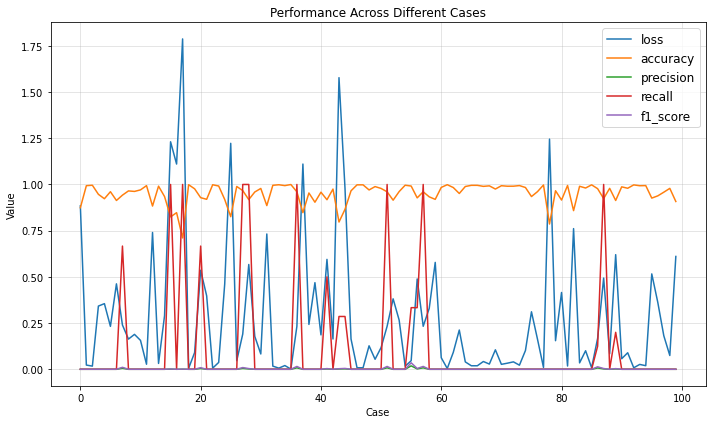

In [123]:
fig, ax = plt.subplots(figsize=(10, 6))
for col in result_eval_pairs1.columns:
    ax.plot(range(len(result_eval_pairs1)), result_eval_pairs1[col], label=col)
plt.legend(fontsize=12)
plt.xlabel("Case")
plt.ylabel("Value")
plt.title("Performance Across Different Cases")
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show()

In [124]:
lst_citate = np.random.choice(document_embeddings_test.shape[0], 300)

In [125]:
result_eval_pairs2 = evaluate_pairs(lst_citate, model1, cite_in_train=True)

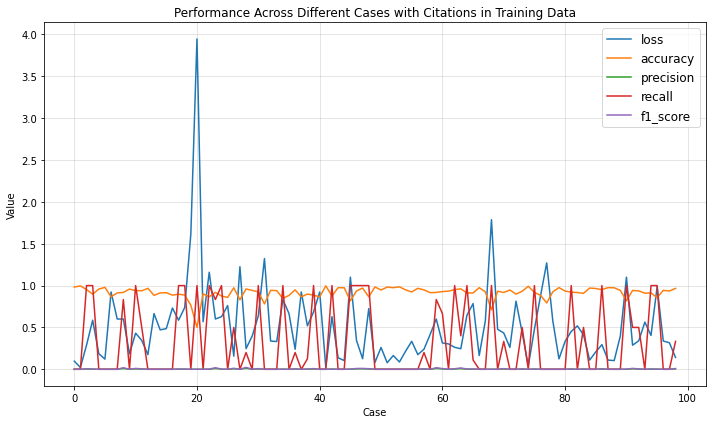

In [126]:
fig, ax = plt.subplots(figsize=(10, 6))
for col in result_eval_pairs2.columns:
    ax.plot(range(len(result_eval_pairs2)), result_eval_pairs2[col], label=col)
plt.legend(fontsize=12)
plt.xlabel("Case")
plt.ylabel("Value")
plt.title("Performance Across Different Cases with Citations in Training Data")
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show()

In [127]:
result_eval_pairs2.mean(axis=0)

loss         0.516181
accuracy     0.916418
precision    0.001483
recall       0.334035
f1_score     0.002931
dtype: float64

### Method 2: FFNN with self-defined early-stopping condition (recall)

[Return to top](#Notebook-contents)

In [128]:
dropout_rate = 0.2
batch_size = 32
epochs = 200
verbose = 1

In [129]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, \
                            TimeDistributed, GRU, Dropout, Bidirectional, \
                            Conv1D, BatchNormalization

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_recall', min_delta=0, patience=50, verbose=1, mode='max',
    baseline=None, restore_best_weights=False
)

model2 = Sequential([
    Dense(512, activation='relu', input_shape=(x_train_score.shape[1], )),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(rate=dropout_rate),
    Dense(32, activation= 'relu'),
    Dense(1, activation= 'sigmoid')])

> We are dealing with imbalanced dataset, and we want to make our prediction of citations be more correct, so we introduce recall for early stopping. The recall is the measure of our model correctly identifying True Positives. 

In [130]:
from tensorflow.keras.optimizers import Adam
import tensorflow
optimizer = Adam(learning_rate=0.0001)
loss = "binary_crossentropy"
metrics = [tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
           tensorflow.keras.metrics.Precision(name='precision'),
           tensorflow.keras.metrics.Recall(name='recall')]
# metrics = [
#       tensorflow.keras.metrics.TruePositives(name='tp'),
#       tensorflow.keras.metrics.FalsePositives(name='fp'),
#       tensorflow.keras.metrics.TrueNegatives(name='tn'),
#       tensorflow.keras.metrics.FalseNegatives(name='fn'), 
#       tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tensorflow.keras.metrics.Precision(name='precision'),
#       tensorflow.keras.metrics.Recall(name='recall'),
#       tensorflow.keras.metrics.AUC(name='auc'),
#       tensorflow.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
# ]
# Compile model
model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [131]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               786944    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [132]:
history = model2.fit(x_train_score, y_train_score, batch_size=batch_size, epochs=epochs, 
                    verbose=verbose, validation_data=(x_val_score, y_val_score), callbacks=[callback])

Epoch 1/200
352/352 [==============================] - 2s 5ms/step - loss: 0.4696 - accuracy: 0.8174 - precision: 0.2467 - recall: 0.0286 - val_loss: 0.4299 - val_accuracy: 0.8227 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
352/352 [==============================] - 1s 4ms/step - loss: 0.4009 - accuracy: 0.8286 - precision: 0.5821 - recall: 0.0448 - val_loss: 0.3811 - val_accuracy: 0.8307 - val_precision: 0.7206 - val_recall: 0.0737
Epoch 3/200
352/352 [==============================] - 1s 4ms/step - loss: 0.3545 - accuracy: 0.8513 - precision: 0.6779 - recall: 0.2516 - val_loss: 0.3608 - val_accuracy: 0.8448 - val_precision: 0.6797 - val_recall: 0.2361
Epoch 4/200
352/352 [==============================] - 1s 4ms/step - loss: 0.3246 - accuracy: 0.8598 - precision: 0.6506 - recall: 0.3475 - val_loss: 0.3480 - val_accuracy: 0.8515 - val_precision: 0.6812 - val_recall: 0.3053
Epoch 5/200
352/352 [==============================] - 1s 4ms/step - loss: 0.3045 - accuracy

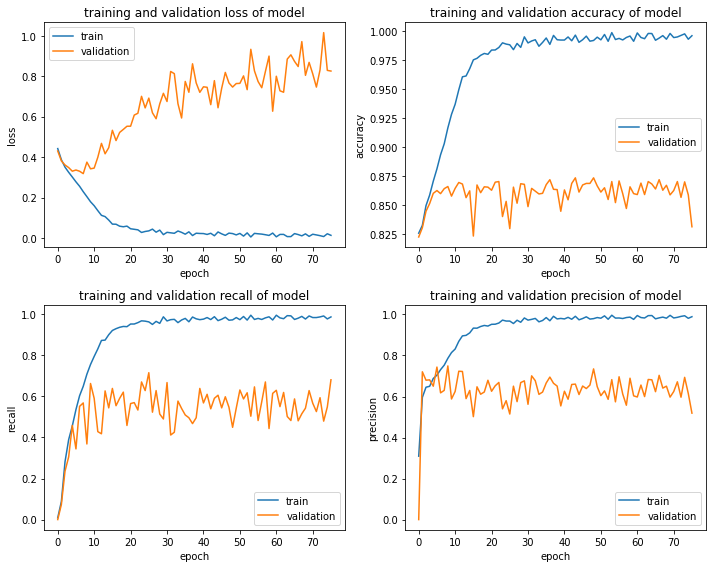

In [133]:
fig, ax = plt.subplots(2, 2, figsize = (10, 8))
ax = ax.ravel()
label = ["loss", "accuracy", "recall", "precision"]
for i in range(4):
    ax[i].plot(history.history[label[i]], label = "train")
    ax[i].plot(history.history['val_' + label[i]], label = "validation")
    ax[i].set_title('training and validation ' + label[i] + ' of model')
    ax[i].set_ylabel(label[i])
    ax[i].set_xlabel('epoch')
    ax[i].legend()

plt.tight_layout()

In [134]:
model2.evaluate(x_test_score_acc, y_test_score_acc)

21/21 [==============================] - 0s 2ms/step - loss: 2.2454 - accuracy: 0.6488 - precision: 1.0000 - recall: 0.6488


[2.245447874069214, 0.648809552192688, 1.0, 0.648809552192688]

In [135]:
evaluate_random_pairs(lst, model2)

======== case 957 ========
202/202 [==============================] - 0s 2ms/step - loss: 0.5288 - accuracy: 0.8702 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          5618  838
======== case 84 ========
202/202 [==============================] - 1s 2ms/step - loss: 0.5672 - accuracy: 0.9061 - precision: 0.0033 - recall: 1.0000
Predicted   0.0  1.0
Actual              
0          5848  606
1             0    2
======== case 549 ========
202/202 [==============================] - 1s 2ms/step - loss: 0.6314 - accuracy: 0.8042 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0   1.0
Actual               
0          5192  1264
======== case 90 ========
202/202 [==============================] - 0s 2ms/step - loss: 0.6570 - accuracy: 0.8614 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          5561  895
======== case 474 ========
202/202 [==============================] - 0s 2ms/step - loss: 

In [136]:
result_eval_pairs3 = evaluate_pairs(lst_eval, model2)

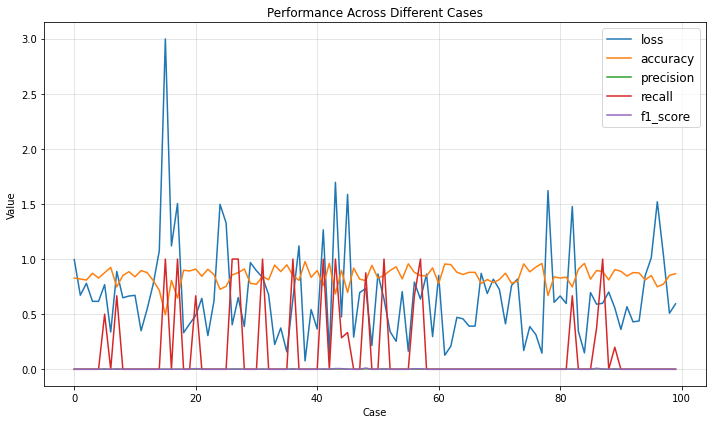

In [137]:
fig, ax = plt.subplots(figsize=(10, 6))
for col in result_eval_pairs3.columns:
    ax.plot(range(len(result_eval_pairs3)), result_eval_pairs3[col], label=col)
plt.legend(fontsize=12)
plt.xlabel("Case")
plt.ylabel("Value")
plt.title("Performance Across Different Cases")
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show()

In [138]:
result_eval_pairs4 = evaluate_pairs(lst_citate, model2, cite_in_train=True)

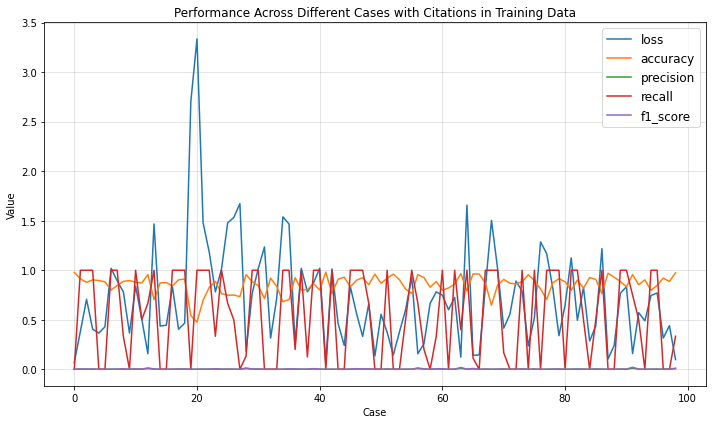

In [139]:
fig, ax = plt.subplots(figsize=(10, 6))
for col in result_eval_pairs4.columns:
    ax.plot(range(len(result_eval_pairs4)), result_eval_pairs4[col], label=col)
plt.legend(fontsize=12)
plt.xlabel("Case")
plt.ylabel("Value")
plt.title("Performance Across Different Cases with Citations in Training Data")
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show()

### Method 3: LSTM Model

[Return to top](#Notebook-contents)

In [140]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=50, verbose=0, mode='max',
    baseline=None, restore_best_weights=False
)

metrics = [tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
           tensorflow.keras.metrics.Precision(name='precision'),
           tensorflow.keras.metrics.Recall(name='recall')]

optimizer = Adam(learning_rate=0.0001)

model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', input_shape = (None, x_train_score.shape[1]), return_sequences = True),
    tf.keras.layers.LSTM(64, activation='relu', input_shape = (None, x_train_score.shape[1]), return_sequences = True),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences = True),
    tf.keras.layers.LSTM(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')]
)


model_lstm.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=metrics)
filename = "best_model2.h5"
checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         852480    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          12416     
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 917,457
Trainable params: 917,457
Non-trainable params: 0
________________________________________________

In [141]:
X_train = np.reshape(np.array(x_train_score), (x_train_score.shape[0], 1, x_train_score.shape[1]))
X_val = np.reshape(np.array(x_val_score), (x_val_score.shape[0], 1, x_val_score.shape[1]))
history = model_lstm.fit(X_train, y_train_score, batch_size = 128, epochs = 200, callbacks=[checkpoint, callback], \
                      validation_data=(X_val, y_val_score))

Epoch 1/200
88/88 [==============================] - 5s 21ms/step - loss: 0.6565 - accuracy: 0.8184 - precision: 0.2498 - recall: 0.0196 - val_loss: 0.4644 - val_accuracy: 0.8227 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
88/88 [==============================] - 1s 13ms/step - loss: 0.4623 - accuracy: 0.8265 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4468 - val_accuracy: 0.8227 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
88/88 [==============================] - 1s 12ms/step - loss: 0.4306 - accuracy: 0.8331 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4317 - val_accuracy: 0.8227 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
88/88 [==============================] - 1s 12ms/step - loss: 0.4209 - accuracy: 0.8289 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4116 - val_accuracy: 0.8227 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/200
88/88 [=============================

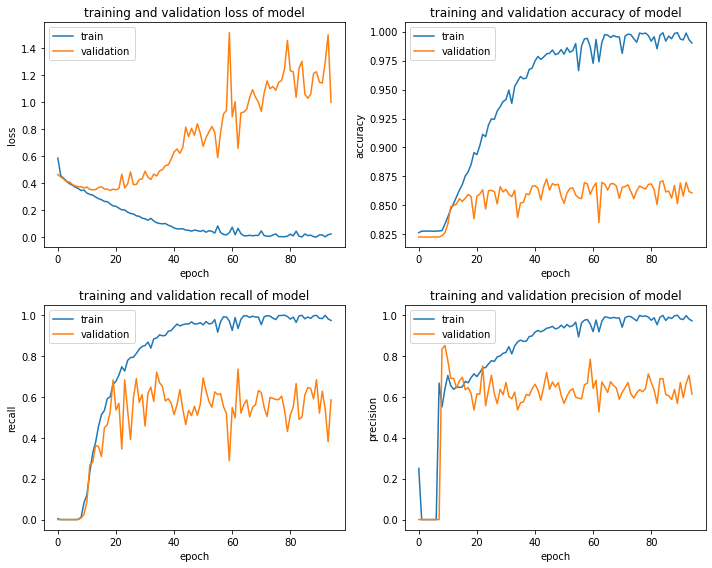

In [142]:
fig, ax = plt.subplots(2, 2, figsize = (10, 8))
ax = ax.ravel()
label = ["loss", "accuracy", "recall", "precision"]
for i in range(4):
    ax[i].plot(history.history[label[i]], label = "train")
    ax[i].plot(history.history['val_' + label[i]], label = "validation")
    ax[i].set_title('training and validation ' + label[i] + ' of model')
    ax[i].set_ylabel(label[i])
    ax[i].set_xlabel('epoch')
    ax[i].legend()

plt.tight_layout()

In [143]:
X_test = np.reshape(np.array(x_test_score_acc), (x_test_score_acc.shape[0], 1, x_test_score_acc.shape[1]))
model_lstm.evaluate(X_test, y_test_score_acc)

21/21 [==============================] - 1s 3ms/step - loss: 6.3871 - accuracy: 0.4449 - precision: 1.0000 - recall: 0.4449


[6.387121200561523, 0.4449404776096344, 1.0, 0.4449404776096344]

In [144]:
evaluate_random_pairs(lst, model_lstm, lstm=True)

======== case 957 ========
202/202 [==============================] - 1s 3ms/step - loss: 0.6651 - accuracy: 0.8502 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          5489  967
======== case 84 ========
202/202 [==============================] - 1s 3ms/step - loss: 0.1823 - accuracy: 0.9565 - precision: 0.0036 - recall: 0.5000
Predicted   0.0  1.0
Actual              
0          6174  280
1             1    1
======== case 549 ========
202/202 [==============================] - 1s 3ms/step - loss: 0.0321 - accuracy: 0.9887 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          6383   73
======== case 90 ========
202/202 [==============================] - 1s 3ms/step - loss: 0.3613 - accuracy: 0.9247 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          5970  486
======== case 474 ========
202/202 [==============================] - 1s 3ms/step - loss: 0.0

In [145]:
result_eval_pairs5 = evaluate_pairs(lst_eval, model_lstm, lstm=True)

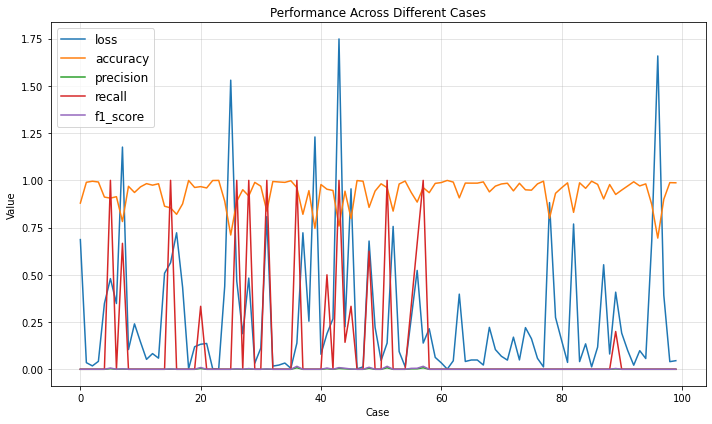

In [146]:
fig, ax = plt.subplots(figsize=(10, 6))
for col in result_eval_pairs5.columns:
    ax.plot(range(len(result_eval_pairs5)), result_eval_pairs5[col], label=col)
plt.legend(fontsize=12)
plt.xlabel("Case")
plt.ylabel("Value")
plt.title("Performance Across Different Cases")
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show()

In [147]:
result_eval_pairs6 = evaluate_pairs(lst_citate, model_lstm, cite_in_train=True, lstm=True)

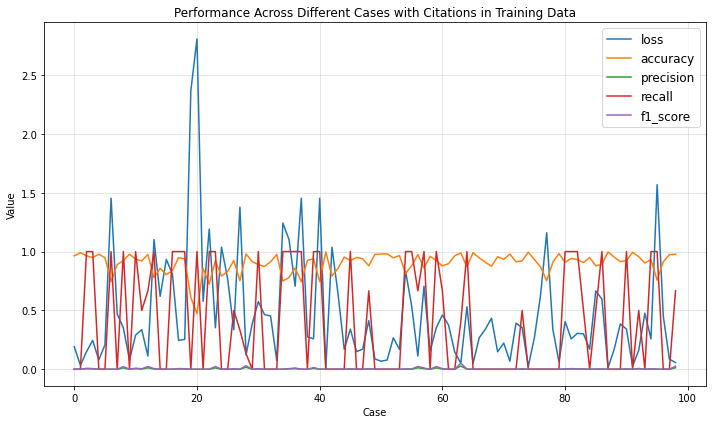

In [148]:
fig, ax = plt.subplots(figsize=(10, 6))
for col in result_eval_pairs6.columns:
    ax.plot(range(len(result_eval_pairs6)), result_eval_pairs6[col], label=col)
plt.legend(fontsize=12)
plt.xlabel("Case")
plt.ylabel("Value")
plt.title("Performance Across Different Cases with Citations in Training Data")
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show()

### Additional Thinking

[Return to top](#Notebook-contents)

In [149]:
# class NonMasking(keras.layers.Layer):   
#     def __init__(self, **kwargs):   
#         self.supports_masking = True  
#         super(NonMasking, self).__init__(**kwargs)   
  
#     def build(self, input_shape):   
#         input_shape = input_shape   
  
#     def compute_mask(self, input, input_mask=None):   
#         # do not pass the mask to the next layers   
#         return None   
  
#     def call(self, x, mask=None):   
#         return x   
  
#     def get_output_shape_for(self, input_shape):   
#         return input_shape

# inputs = model.inputs
# bert_out = NonMasking()(model.outputs)

# bert_out = SpatialDropout1D(0.2)(bert_out)

# l_embedding = Lambda(lambda x: K.concatenate([K.zeros(shape=(K.shape(x)[0], 1, K.shape(x)[-1])),
#                                                       x[:, :-1]], axis=1))(bert_out)
        
# r_embedding = Lambda(lambda x: K.concatenate([K.zeros(shape=(K.shape(x)[0], 1, K.shape(x)[-1])),
#                                                       x[:, 1:]], axis=1))(bert_out)

# forward = LSTM(256, return_sequences=True)(l_embedding) 
# backward = LSTM(256, return_sequences=True, go_backwards=True)(r_embedding)
# backward = Lambda(lambda x: K.reverse(x, axes=1))(backward)

# together = [forward, bert_out , backward]

# together = Concatenate(axis=2)(together)

# semantic = Conv1D(256, kernel_size=1, activation="relu")(together)
# sentence_embed = Lambda(lambda x: K.max(x, axis=1))(semantic)

# dense_layer = Dense(256, activation='relu')(sentence_embed)
# preds = Dense(1, activation='sigmoid')(dense_layer)
# model1 = Model(inputs, preds)

In [150]:
# def build_CNN():
    
#     embedding_layer = Embedding(config.word_vocab_size,
#                                 config.word_embed_size,
#                                 trainable=True,
#                                 mask_zero = False
#                                 )
        
#     sentence_input = Input(shape=(config.total_num,), dtype='int32')
#     embedded_sequences = embedding_layer(sentence_input)
#     cnninput = Reshape((config.total_num, config.word_embed_size, 1))(embedded_sequences)
#     print (cnninput.shape)
#     cnn2 = Conv2D(filters = 75, kernel_size = (2, config.word_embed_size), data_format='channels_last')(cnninput)
#     print (cnn2.shape)
#     pooling2 = MaxPooling2D(pool_size=(config.total_num + 1 - 2, 1))(cnn2)
#     print (pooling2.shape)
#     pooling2 = Reshape((75,))(pooling2)
#     print (pooling2.shape)
#     cnn3 = Conv2D(filters = 75, kernel_size = (3, config.word_embed_size), data_format='channels_last')(cnninput)
#     pooling3 = MaxPooling2D(pool_size=(config.total_num + 1 - 3, 1))(cnn3)
#     pooling3 = Reshape((75,))(pooling3)
#     cnn4 = Conv2D(filters = 75, kernel_size = (4, config.word_embed_size), data_format='channels_last')(cnninput)
#     pooling4 = MaxPooling2D(pool_size=(config.total_num + 1 - 4, 1))(cnn4)
#     pooling4 = Reshape((75,))(pooling4)
#     cnn5 = Conv2D(filters = 75, kernel_size = (5, config.word_embed_size), data_format='channels_last')(cnninput)
#     pooling5 = MaxPooling2D(pool_size=(config.total_num + 1 - 5, 1))(cnn5)
#     pooling5 = Reshape((75,))(pooling5)
#     feature = concatenate([pooling2, pooling3, pooling4, pooling5])
#     print (feature.shape)
#     feature = Dropout(0.5)(feature)
#     accu_preds = Dense(config.num_accu, activation='softmax', name="accu_preds")(feature)
#     law_preds = Dense(config.num_law, activation='softmax', name="law_preds")(feature)
#     term_preds = Dense(config.num_term, activation='softmax', name="term_preds")(feature)
#     model = Model(inputs=[sentence_input], outputs=[accu_preds, law_preds, term_preds])
                                
#     return model

## Model: Our Proposed Model - LawPairBERT Model with BERT and Graph Embedding

[Return to top](#Notebook-contents)

> In this part, we include Graph Embedding in our LawPairBERT Model. We follow similar process instead of incorporating Graph Embedding.

<div>
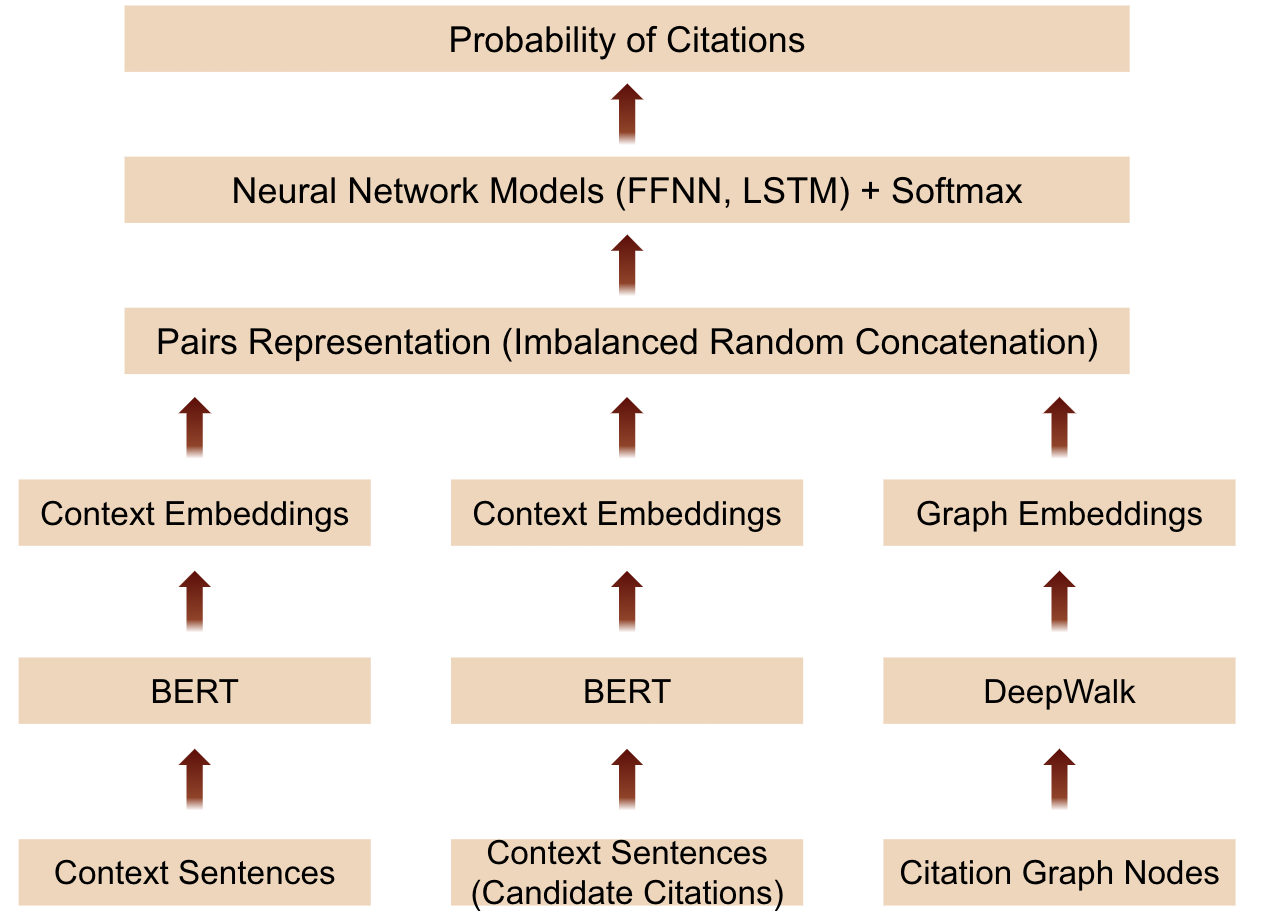
</div>

> Similar to the first version with only BERT Embedding, we also implement Imbalanced Random Concatenation. Here we substitute the previous first embedding with the combination of bert embedding and graph embedding of the first case. And the second one with the second combination and we keep the label the same.

<div>
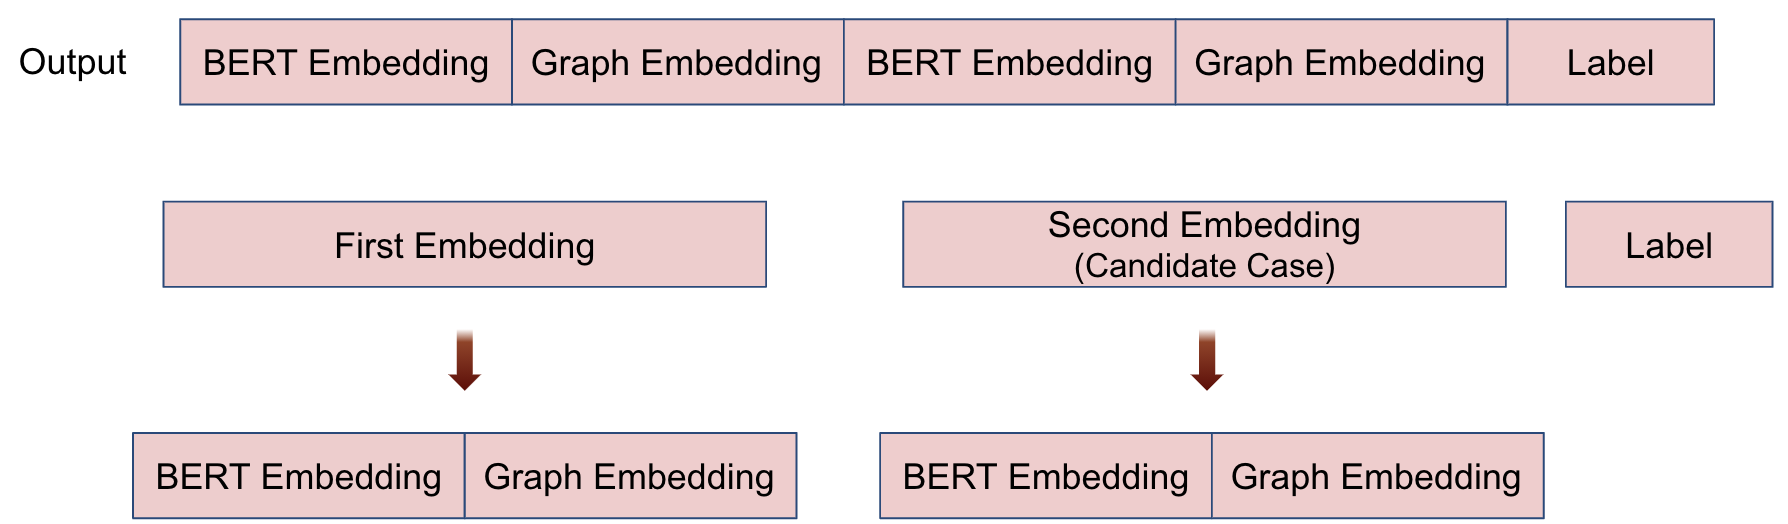
</div>

### Graph Embedding Generation

[Return to top](#Notebook-contents)

> As we have tried a lot of conventional modelings of text and sementic data and get limited accuracy from them, we think that there may be a way to better represent the relationship of these citations. 

> The motivation of using graph embedding is the law citation graph we heard in the project introduction meeting and we see in here： https://github.com/YiAlpha/auto-law-review. Also, using knowledge graph to represent data, such as social media text (https://arxiv.org/abs/2101.06111) and legal documents (https://arxiv.org/pdf/2003.12900.pdf) has been gradually appreciated. Therefore, we want to try on a representation method different from word or sentence embeddings to represent the relationship among citations. Specifically, we choose relatively mature DeepWalk package (https://github.com/phanein/deepwalk) to start with.

> Few concepts of graph theory are worth mentioning here. In a graph, a vertex, or node can be thought as a subject. In our case, each case is a node, the citation cited by the case is also a node. The edge of the graph means the line connecting the nodes. In our case, the edge exists if the case is cited or is citing the another case. The adjacency list is a list that shows all the edge for one node. In our case, if a case is cited by or cisting any other cases (appear together with the other cases), those cases are the adjacencies of the case. 

> We use the citation list provided by HLS case law website to create our adjacency matrix and the edge list. Then, we use DeepWalk to generate the embeddings. 

> To generate graph embedding, we first load adjacency matrix and edge list.

In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
csv_file = '/content/drive/MyDrive/ac209b_project/data/citations.csv'

In [153]:
adj_file = '/content/drive/MyDrive/ac209b_project/data/adj_list.txt'

In [154]:
edge_file = '/content/drive/MyDrive/ac209b_project/data/edge.txt'

In [155]:
import csv
with open(adj_file, "w") as my_output_file:
    with open(csv_file, "r") as my_input_file:
        [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()

In [156]:
adj_list = pd.read_csv(csv_file, sep='delimiter', header=None)
tmp = adj_list.iloc[:,0].str.split(',')
edge_list = []
for i in range(len(tmp)):
  a_row = tmp[i]

  for j in range(len(a_row)-1):
    edge = [int(a_row[0]), int(a_row[j+1])]
    edge_list.append(edge)
edgefile = open(edge_file, "w")
for edge in edge_list:
  for element in edge:
    edgefile.write(str(element) + " ")
  edgefile.write("\n")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [157]:
%cd /content/drive/MyDrive/ac209b_project/deepwalk/
!pip install -r requirements.txt
!python /content/drive/MyDrive/ac209b_project/deepwalk/setup.py install

/content/drive/.shortcut-targets-by-id/1SvnzitetMj-uigpJl1EXa_mA_8-OlLGd/ac209b_project/deepwalk
running install
running bdist_egg
running egg_info
writing deepwalk.egg-info/PKG-INFO
writing dependency_links to deepwalk.egg-info/dependency_links.txt
writing entry points to deepwalk.egg-info/entry_points.txt
writing requirements to deepwalk.egg-info/requires.txt
writing top-level names to deepwalk.egg-info/top_level.txt
adding license file 'LICENSE' (matched pattern 'LICEN[CS]E*')
adding license file 'AUTHORS.rst' (matched pattern 'AUTHORS*')
reading manifest file 'deepwalk.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'deepwalk.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/deepwalk
copying build/lib/deepwalk/graph.py -> build/bdist.linux-x86_64/egg/deepwalk
copying build/lib/deepwalk/__init__.py -> build/b

In [158]:
!pwd

/content/drive/.shortcut-targets-by-id/1SvnzitetMj-uigpJl1EXa_mA_8-OlLGd/ac209b_project/deepwalk


In [159]:
!deepwalk --input ../data/adj_list.txt --output ../data/adj_embeddings.txt

Number of nodes: 78073
Number of walks: 780730
Data size (walks*length): 31229200
Walking...



In [160]:
!deepwalk --input ../data/edge.txt --output ../data/edge_embeddings.txt

Number of nodes: 73903
Number of walks: 739030
Data size (walks*length): 29561200
Walking...
Traceback (most recent call last):



In [161]:
adj_matrix = np.loadtxt('/content/drive/MyDrive/ac209b_project/data/adj_embeddings.txt',skiprows=1)

In [162]:
edge_matrix = np.loadtxt('/content/drive/MyDrive/ac209b_project/data/edge_embeddings.txt',skiprows=1)

In [163]:
adj_df = pd.DataFrame(adj_matrix)
edge_df = pd.DataFrame(edge_matrix)
adj_df.columns = ['rw_' + str(i) for i in range( len(adj_df.columns))]
edge_df.columns = ['rw_' + str(i) for i in range( len(edge_df.columns))]
adj_df.iloc[:,0] = adj_df.iloc[:,0].astype(int)
edge_df.iloc[:,0] = edge_df.iloc[:,0].astype(int)
adj_df.iloc[:,0] = adj_df.iloc[:,0].rename('case_id')
adj_df = adj_df.rename(columns={'rw_0':'case_id'})
edge_df = edge_df.rename(columns={'rw_0':'case_id'})

In [164]:
adj_df.head()

case_id      rw_1      rw_2  ...     rw_62     rw_63     rw_64
0  8565416  0.066680 -0.368407  ...  0.008758  0.193680 -0.131688
1  8629835  0.166232 -0.431057  ... -0.182404  0.121330 -0.145139
2  8561041  0.387454 -0.074344  ... -0.225378 -0.140718  0.044057
3  8573434  0.135760 -0.436850  ...  0.056972  0.272511 -0.264871
4  8559773  0.235543 -0.359268  ... -0.092804  0.182350 -0.316375

[5 rows x 65 columns]

In [165]:
edge_df.head()

case_id      rw_1      rw_2  ...     rw_62     rw_63     rw_64
0  12170267 -0.243739  0.003311  ... -0.115378 -0.611643  0.101173
1   8596105  0.735233  0.213110  ... -0.697519 -0.406288  0.334973
2  12129791  0.723937  0.138962  ... -0.349400  0.082189  0.183333
3  12167679 -0.096296  0.201332  ...  0.085653  0.739037 -0.079223
4   8573434 -0.360887 -1.251245  ...  0.376515 -0.273749 -0.152409

[5 rows x 65 columns]

In [166]:
p = pd.read_csv('/content/drive/MyDrive/ac209b_project/data/edge_embeddings.csv')

In [167]:
metadata = pd.read_csv('/content/drive/MyDrive/ac209b_project/data/metadata.csv')

In [168]:
metadata.head()

id        frontend_url  ... decision_date_original              cites
0     53835  /nc/345/342/53835/  ...             1997-02-07       345 N.C. 342
1  11912589    /nc-app/123/210/  ...             1996-07-16  123 N.C. App. 210
2     53836  /nc/345/752/53836/  ...             1997-04-10       345 N.C. 752
3  11868356    /nc-app/125/416/  ...             1997-02-18  125 N.C. App. 416
4     53838  /nc/345/344/53838/  ...             1997-02-07       345 N.C. 344

[5 rows x 11 columns]

In [169]:
opinion_df = pd.read_csv('/content/drive/MyDrive/ac209b_project/data/opinions.csv')
opinion_df = opinion_df.iloc[:,1:]
opinion_df.head()

id  ...                                       text_wheader
0  8521088  ...  JAMES L. OLIVER, JR., and CRAVEN VENTURE MANAG...
1  8564338  ...  BRIAN FLIPPIN, by his Guardian ad Litem, MELVI...
2  8561053  ...  STILLWELL ENTERPRISES, INC., Plaintiff v. INTE...
3  8597345  ...  EDNA R. LEAK BRUTON and EDNA R. LEAK BRUTON, T...
4  8561636  ...  MRS. RUBY W. PETTY, Widow, EDGAR PETTY, Deceas...

[5 rows x 11 columns]

In [170]:
opinion_rw_df = opinion_df.merge(adj_df, how='left',left_on='id', right_on='case_id',left_index=True)
opinion_rw_df = opinion_rw_df.drop('case_id', axis=1)

In [171]:
opinion_rw_df.to_csv('/content/drive/MyDrive/ac209b_project/data/opinion_rw.csv')

In [172]:
# Then we get the graph embedding for further modeling

> Then we load the graph embedding for further modeling.

In [173]:
graph_embedding = pd.read_csv('/content/drive/MyDrive/ac209b_project/data/opinion_rw.csv', index_col=0).reset_index(drop=True)
selected_col = ["id"]
for i in range(1, 65):
    selected_col.append("rw_" + str(i))
graph_embedding = graph_embedding[selected_col]

In [174]:
print(graph_embedding.shape)
print(graph_embedding.head())

(7630, 65)
        id      rw_1      rw_2  ...     rw_62     rw_63     rw_64
0  8521088  0.373284 -0.443687  ... -0.216955 -0.051338 -0.008346
1  8564338  0.599098  0.441042  ...  0.098978 -0.243899  0.283122
2  8561053  0.251257  0.220364  ... -0.294928 -0.260612 -0.616091
3  8597345  0.247056 -0.180485  ...  0.087588 -0.006164  0.203303
4  8561636 -0.012970 -0.119644  ... -0.098092  0.109254  0.363923

[5 rows x 65 columns]


In [175]:
graph_index = list(graph_embedding["id"].values)
graph_temp = []
y_train_graph = []
selected_col.remove("id")
for i in range(document_embeddings.shape[0]):
    index1 = graph_index.index(train_data_mod["id"].values[i])
    graph_embed1 = graph_embedding.loc[index1, selected_col].values
    for element in train_data_mod["cites_list"].values[i]:
        if element in train_citations:
            index_citate = train_citations.index(element)
            index2 = graph_index.index(train_data_mod["id"].values[index_citate])
            graph_embed2 = graph_embedding.loc[index2, selected_col].values
            curr_arr = np.concatenate((document_embeddings[i, :], graph_embed1, document_embeddings[index_citate, :], graph_embed2)).reshape((document_embeddings.shape[1]*2 + 64*2, 1))
            graph_temp.append(curr_arr)
            y_train_graph.append(1)

In [176]:
results_false_graph = []
for i in range(document_embeddings.shape[0]):
    index1 = graph_index.index(train_data_mod["id"].values[i])
    graph_embed1 = graph_embedding.loc[index1, selected_col].values
    if len(y_train_score) >= 15000:
        break
    lst = np.random.choice(document_embeddings.shape[0], 3)
    for j in lst:
        element = train_data_mod["citation"].values[j][0]["cite"]
        if j != i and element not in train_data_mod["cites_list"].values[i] and element in train_citations:
            index_citate = train_citations.index(element)
            index2 = graph_index.index(train_data_mod["id"].values[index_citate])
            graph_embed2 = graph_embedding.loc[index2, selected_col].values
            curr_arr = np.concatenate((document_embeddings[i, :], graph_embed1, document_embeddings[index_citate, :], graph_embed2)).reshape((document_embeddings.shape[1]*2 + 64*2, 1))
            if not any(np.array_equal(np.around(curr_arr, 4), x) for x in results_false_graph):
                results_false_graph.append(np.around(curr_arr, 4))
                graph_temp.append(curr_arr)
                y_train_graph.append(0)
x_train_graph = np.concatenate(graph_temp, axis=1).T
y_train_graph = np.array(y_train_graph)

x_train_graph, x_val_graph, y_train_graph, y_val_graph = train_test_split(x_train_graph, y_train_graph, test_size=0.25)

### Method 1: FFNN (2)

[Return to top](#Notebook-contents)

In [177]:
x_train_graph = np.nan_to_num(x_train_graph, 0.)
x_val_graph = np.nan_to_num(x_val_graph, 0.)

In [178]:
dropout_rate = 0.2
batch_size = 32
epochs = 200
verbose = 1

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=50, verbose=1, mode='max',
    baseline=None, restore_best_weights=False
)

model1 = Sequential([
    Dense(512, activation='relu', input_shape=(x_train_graph.shape[1], )),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(rate=dropout_rate),
    Dense(32, activation= 'relu'),
    Dense(1, activation= 'sigmoid')])

In [179]:
optimizer = Adam(learning_rate=0.0001)
loss = "binary_crossentropy"
metrics = [tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
           tensorflow.keras.metrics.Precision(name='precision'),
           tensorflow.keras.metrics.Recall(name='recall')]
# Compile model
model1.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [180]:
history = model1.fit(x_train_graph, y_train_graph, batch_size=batch_size, epochs=epochs, 
                    verbose=verbose, validation_data=(x_val_graph, y_val_graph), callbacks=[callback])

Epoch 1/200
515/515 [==============================] - 4s 5ms/step - loss: 0.3561 - accuracy: 0.8854 - precision: 0.2166 - recall: 1.8750e-04 - val_loss: 0.2958 - val_accuracy: 0.8816 - val_precision: 1.0000 - val_recall: 0.0031
Epoch 2/200
515/515 [==============================] - 2s 4ms/step - loss: 0.2813 - accuracy: 0.8886 - precision: 0.6576 - recall: 0.0617 - val_loss: 0.2734 - val_accuracy: 0.8871 - val_precision: 0.7286 - val_recall: 0.0782
Epoch 3/200
515/515 [==============================] - 2s 4ms/step - loss: 0.2321 - accuracy: 0.9044 - precision: 0.7184 - recall: 0.2747 - val_loss: 0.2465 - val_accuracy: 0.8982 - val_precision: 0.6768 - val_recall: 0.2730
Epoch 4/200
515/515 [==============================] - 2s 4ms/step - loss: 0.2153 - accuracy: 0.9127 - precision: 0.7144 - recall: 0.4485 - val_loss: 0.2368 - val_accuracy: 0.9046 - val_precision: 0.6693 - val_recall: 0.3880
Epoch 5/200
515/515 [==============================] - 2s 4ms/step - loss: 0.1778 - accuracy: 0.

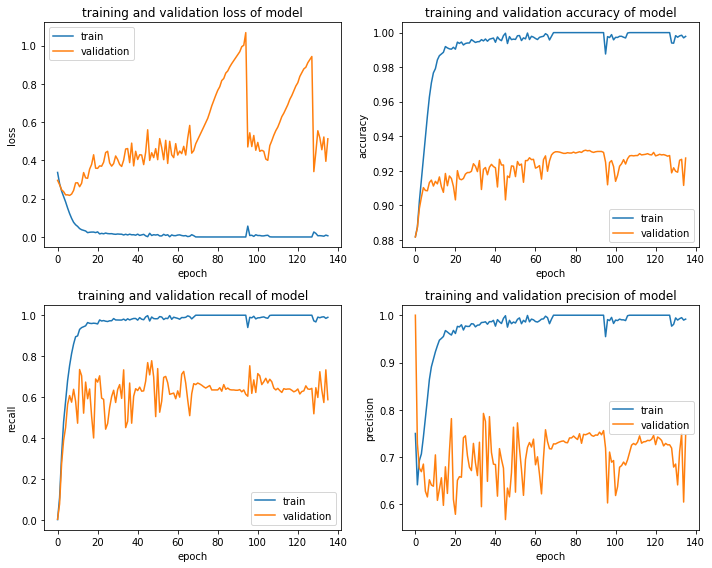

In [181]:
fig, ax = plt.subplots(2, 2, figsize = (10, 8))
ax = ax.ravel()
label = ["loss", "accuracy", "recall", "precision"]
for i in range(4):
    ax[i].plot(history.history[label[i]], label = "train")
    ax[i].plot(history.history['val_' + label[i]], label = "validation")
    ax[i].set_title('training and validation ' + label[i] + ' of model')
    ax[i].set_ylabel(label[i])
    ax[i].set_xlabel('epoch')
    ax[i].legend()

plt.tight_layout()

In [182]:
results_test_acc = []
y_test_score_acc = []
for i in range(document_embeddings_test.shape[0]):
    index1 = graph_index.index(test_data_mod["id"].values[i])
    graph_embed1 = graph_embedding.loc[index1, selected_col].values
    for element in test_data_mod["cites_list"].values[i]:
        if element in train_citations:
            index_citate = train_citations.index(element)
            index2 = graph_index.index(train_data_mod["id"].values[index_citate])
            graph_embed2 = graph_embedding.loc[index2, selected_col].values
            curr_arr = np.concatenate((document_embeddings[i, :], graph_embed1, document_embeddings[index_citate, :], graph_embed2)).reshape((document_embeddings.shape[1]*2 + 64*2, 1))
            results_test_acc.append(curr_arr)
            y_test_score_acc.append(1)

x_test_score_acc = np.concatenate(results_test_acc, axis=1).T
x_test_score_acc = np.nan_to_num(x_test_score_acc, 0.)
y_test_score_acc = np.array(y_test_score_acc)
model1.evaluate(x_test_score_acc, y_test_score_acc)

21/21 [==============================] - 0s 2ms/step - loss: 15.6627 - accuracy: 0.0967 - precision: 1.0000 - recall: 0.0967


[15.6627197265625, 0.096726194024086, 1.0, 0.096726194024086]

In [183]:
def evaluate_random_pairs_graph(lst, model, lstm=False):
    for i in lst:
        results_test = []
        y_test_score = []
        index1 = graph_index.index(test_data_mod["id"].values[i])
        graph_embed1 = graph_embedding.loc[index1, selected_col].values
        for j in range(document_embeddings.shape[0]):
            element = train_data_mod["citation"].values[j][0]["cite"]
            if j != i and element not in test_data_mod["cites_list"].values[i] and element in train_citations:
                index_citate = train_citations.index(element)
                index2 = graph_index.index(train_data_mod["id"].values[index_citate])
                graph_embed2 = graph_embedding.loc[index2, selected_col].values
                curr_arr = np.concatenate((document_embeddings[i, :], graph_embed1, document_embeddings[index_citate, :], graph_embed2)).reshape((document_embeddings.shape[1]*2 + 64*2, 1))
                results_test.append(curr_arr)
                y_test_score.append(0)
            elif j != i and element in test_data_mod["cites_list"].values[i] and element in train_citations:
                index_citate = train_citations.index(element)
                index2 = graph_index.index(train_data_mod["id"].values[index_citate])
                graph_embed2 = graph_embedding.loc[index2, selected_col].values
                curr_arr = np.concatenate((document_embeddings[i, :], graph_embed1, document_embeddings[index_citate, :], graph_embed2)).reshape((document_embeddings.shape[1]*2 + 64*2, 1))
                results_test.append(curr_arr)
                y_test_score.append(1)
        x_test_score = np.concatenate(results_test, axis=1).T
        x_test_score = np.nan_to_num(x_test_score, 0.)
        y_test_score = np.array(y_test_score)
        print("======== case " + str(i) + " ========")
        if lstm:
            x_test_score = np.reshape(np.array(x_test_score), (x_test_score.shape[0], 1, x_test_score.shape[1]))
        model.evaluate(x_test_score, y_test_score)
        y_pred = model.predict(x_test_score).round(0)
        y_actu = pd.Series(y_test_score, name='Actual')
        y_pred_df = pd.Series(y_pred.flatten(), name='Predicted')
        print(pd.crosstab(y_actu, y_pred_df))

In [184]:
lst = [957, 84, 549, 90, 474, 243, 766, 695, 163, 817]

In [185]:
evaluate_random_pairs_graph(lst, model1)

======== case 957 ========
202/202 [==============================] - 1s 3ms/step - loss: 0.0141 - accuracy: 0.9977 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          6441   15
======== case 84 ========
202/202 [==============================] - 1s 3ms/step - loss: 0.0204 - accuracy: 0.9967 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          6435   19
1             2    0
======== case 549 ========
202/202 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9986 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          6447    9
======== case 90 ========
202/202 [==============================] - 1s 2ms/step - loss: 0.0097 - accuracy: 0.9972 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          6438   18
======== case 474 ========
202/202 [==============================] - 1s 2ms/step - l

In [186]:
from sklearn.metrics import f1_score

def evaluate_pairs_graph(lst, model, lstm=False, cite_in_train=False):
    f1_val = []
    result = pd.DataFrame(columns=model.metrics_names)
    for i in lst:
        results_test = []
        y_test_score = []
        index1 = graph_index.index(test_data_mod["id"].values[i])
        graph_embed1 = graph_embedding.loc[index1, selected_col].values
        for j in range(document_embeddings.shape[0]):
            element = train_data_mod["citation"].values[j][0]["cite"]
            if j != i and element not in test_data_mod["cites_list"].values[i] and element in train_citations:
                index_citate = train_citations.index(element)
                index2 = graph_index.index(train_data_mod["id"].values[index_citate])
                graph_embed2 = graph_embedding.loc[index2, selected_col].values
                curr_arr = np.concatenate((document_embeddings[i, :], graph_embed1, document_embeddings[index_citate, :], graph_embed2)).reshape((document_embeddings.shape[1]*2 + 64*2, 1))
                results_test.append(curr_arr)
                y_test_score.append(0)
            elif j != i and element in test_data_mod["cites_list"].values[i] and element in train_citations:
                index_citate = train_citations.index(element)
                index2 = graph_index.index(train_data_mod["id"].values[index_citate])
                graph_embed2 = graph_embedding.loc[index2, selected_col].values
                curr_arr = np.concatenate((document_embeddings[i, :], graph_embed1, document_embeddings[index_citate, :], graph_embed2)).reshape((document_embeddings.shape[1]*2 + 64*2, 1))
                results_test.append(curr_arr)
                y_test_score.append(1)
        if cite_in_train and sum(y_test_score) == 0.:
            continue
        x_test_score = np.concatenate(results_test, axis=1).T
        x_test_score = np.nan_to_num(x_test_score, 0.)
        y_test_score = np.array(y_test_score)
        if lstm:
            x_test_score = np.reshape(np.array(x_test_score), (x_test_score.shape[0], 1, x_test_score.shape[1]))
        score = model.evaluate(x_test_score, y_test_score, verbose=0)
        result = result.append(pd.Series(score, index = result.columns), ignore_index=True)
        y_pred = model.predict(x_test_score).round(0)
        f1_val.append(f1_score(y_test_score, y_pred))
    result["f1_score"] = f1_val
    return result

In [187]:
lst_eval = np.random.choice(document_embeddings_test.shape[0], 100)

In [188]:
result_eval_pairs1 = evaluate_pairs_graph(lst_eval, model1)

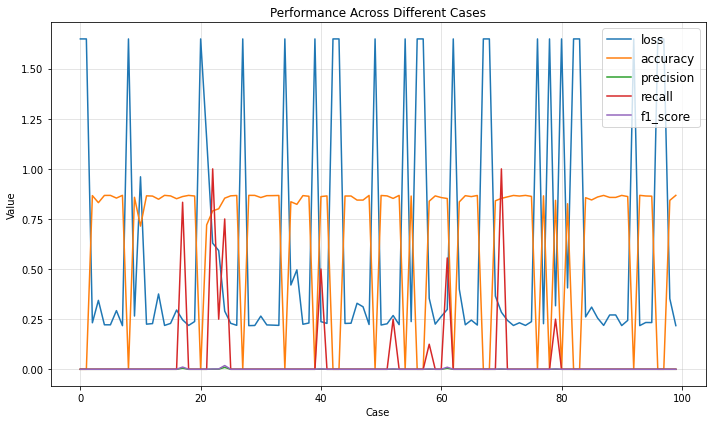

In [189]:
fig, ax = plt.subplots(figsize=(10, 6))
for col in result_eval_pairs1.columns:
    ax.plot(range(len(result_eval_pairs1)), result_eval_pairs1[col], label=col)
plt.legend(fontsize=12)
plt.xlabel("Case")
plt.ylabel("Value")
plt.title("Performance Across Different Cases")
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show()

In [190]:
lst_citate = np.random.choice(document_embeddings_test.shape[0], 300)

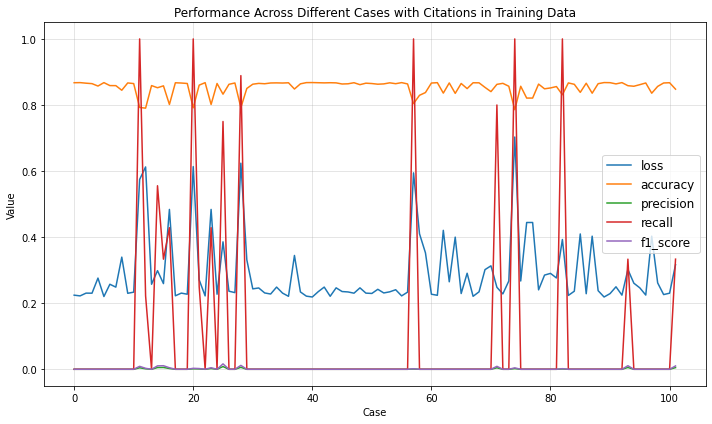

In [191]:
result_eval_pairs2 = evaluate_pairs_graph(lst_citate, model1, cite_in_train=True)
fig, ax = plt.subplots(figsize=(10, 6))
for col in result_eval_pairs2.columns:
    ax.plot(range(len(result_eval_pairs2)), result_eval_pairs2[col], label=col)
plt.legend(fontsize=12)
plt.xlabel("Case")
plt.ylabel("Value")
plt.title("Performance Across Different Cases with Citations in Training Data")
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show()

### Method 2: FFNN with self-defined early-stopping condition (recall) (2)

[Return to top](#Notebook-contents)

In [192]:
dropout_rate = 0.2
batch_size = 32
epochs = 200
verbose = 1

In [193]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, \
                            TimeDistributed, GRU, Dropout, Bidirectional, \
                            Conv1D, BatchNormalization

In [194]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, \
                            TimeDistributed, GRU, Dropout, Bidirectional, \
                            Conv1D, BatchNormalizationcallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_recall', min_delta=0, patience=50, verbose=1, mode='max',
    baseline=None, restore_best_weights=False
)

model2 = Sequential([
    Dense(512, activation='relu', input_shape=(x_train_graph.shape[1], )),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(rate=dropout_rate),
    Dense(32, activation= 'relu'),
    Dense(1, activation= 'sigmoid')])

In [195]:
from tensorflow.keras.optimizers import Adam
import tensorflow
optimizer = Adam(learning_rate=0.0001)
loss = "binary_crossentropy"
metrics = [tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
           tensorflow.keras.metrics.Precision(name='precision'),
           tensorflow.keras.metrics.Recall(name='recall')]

# Compile model
model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [196]:
history = model2.fit(x_train_graph, y_train_graph, batch_size=batch_size, epochs=epochs, 
                    verbose=verbose, validation_data=(x_val_graph, y_val_graph), callbacks=[callback])

Epoch 1/200
515/515 [==============================] - 3s 4ms/step - loss: 0.4025 - accuracy: 0.8557 - precision: 0.1277 - recall: 0.0382 - val_loss: 0.3201 - val_accuracy: 0.8814 - val_precision: 0.5714 - val_recall: 0.0061
Epoch 2/200
515/515 [==============================] - 2s 4ms/step - loss: 0.2967 - accuracy: 0.8893 - precision: 0.7404 - recall: 0.0762 - val_loss: 0.2821 - val_accuracy: 0.8864 - val_precision: 0.6077 - val_recall: 0.1212
Epoch 3/200
515/515 [==============================] - 2s 4ms/step - loss: 0.2489 - accuracy: 0.9002 - precision: 0.6860 - recall: 0.2977 - val_loss: 0.2753 - val_accuracy: 0.8929 - val_precision: 0.7963 - val_recall: 0.1319
Epoch 4/200
515/515 [==============================] - 2s 4ms/step - loss: 0.2168 - accuracy: 0.9137 - precision: 0.7427 - recall: 0.4429 - val_loss: 0.2650 - val_accuracy: 0.8956 - val_precision: 0.6756 - val_recall: 0.2331
Epoch 5/200
515/515 [==============================] - 2s 4ms/step - loss: 0.1844 - accuracy: 0.9242

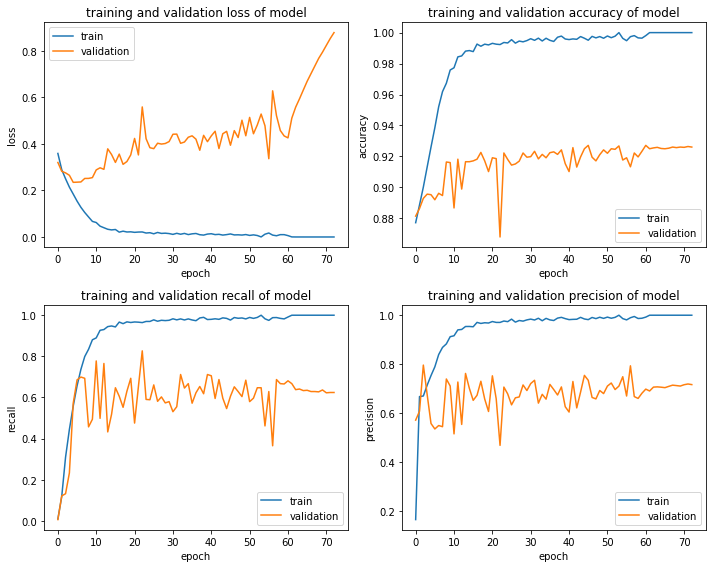

In [197]:
fig, ax = plt.subplots(2, 2, figsize = (10, 8))
ax = ax.ravel()
label = ["loss", "accuracy", "recall", "precision"]
for i in range(4):
    ax[i].plot(history.history[label[i]], label = "train")
    ax[i].plot(history.history['val_' + label[i]], label = "validation")
    ax[i].set_title('training and validation ' + label[i] + ' of model')
    ax[i].set_ylabel(label[i])
    ax[i].set_xlabel('epoch')
    ax[i].legend()

plt.tight_layout()

In [198]:
model2.evaluate(x_test_score_acc, y_test_score_acc)

21/21 [==============================] - 0s 3ms/step - loss: 23.1919 - accuracy: 0.0997 - precision: 1.0000 - recall: 0.0997


[23.191913604736328, 0.0997023805975914, 1.0, 0.0997023805975914]

In [199]:
evaluate_random_pairs_graph(lst, model2)

======== case 957 ========
202/202 [==============================] - 0s 2ms/step - loss: 8.5385e-09 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0
Actual         
0          6456
======== case 84 ========
202/202 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9988 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          6448    6
1             2    0
======== case 549 ========
202/202 [==============================] - 0s 2ms/step - loss: 0.0317 - accuracy: 0.9943 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          6419   37
======== case 90 ========
202/202 [==============================] - 0s 2ms/step - loss: 0.0665 - accuracy: 0.9904 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          6394   62
======== case 474 ========
202/202 [==============================] - 1s 2ms/step - loss: 6.3896

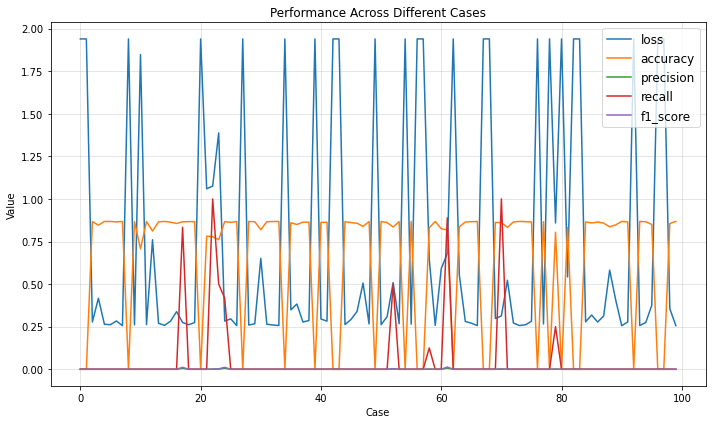

In [200]:
result_eval_pairs1 = evaluate_pairs_graph(lst_eval, model2)
fig, ax = plt.subplots(figsize=(10, 6))
for col in result_eval_pairs1.columns:
    ax.plot(range(len(result_eval_pairs1)), result_eval_pairs1[col], label=col)
plt.legend(fontsize=12)
plt.xlabel("Case")
plt.ylabel("Value")
plt.title("Performance Across Different Cases")
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show()

### Method 3: LSTM Model (2)

[Return to top](#Notebook-contents)

In [201]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=50, verbose=0, mode='max',
    baseline=None, restore_best_weights=False
)

metrics = [tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
           tensorflow.keras.metrics.Precision(name='precision'),
           tensorflow.keras.metrics.Recall(name='recall')]

optimizer = Adam(learning_rate=0.0001)

model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', input_shape = (None, x_train_graph.shape[1]), return_sequences = True),
    tf.keras.layers.LSTM(64, activation='relu', input_shape = (None, x_train_graph.shape[1]), return_sequences = True),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences = True),
    tf.keras.layers.LSTM(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')]
)


model_lstm.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=metrics)
filename = "best_model2.h5"
checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         918016    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          12416     
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 982,993
Trainable params: 982,993
Non-trainable params: 0
________________________________________________

In [202]:
X_train = np.reshape(np.array(x_train_graph), (x_train_graph.shape[0], 1, x_train_graph.shape[1]))
X_val = np.reshape(np.array(x_val_graph), (x_val_graph.shape[0], 1, x_val_graph.shape[1]))

In [203]:
history = model_lstm.fit(X_train, y_train_graph, batch_size = 128, epochs = 200, callbacks=[checkpoint, callback], \
                      validation_data=(X_val, y_val_graph))

Epoch 1/200
129/129 [==============================] - 6s 17ms/step - loss: 0.6309 - accuracy: 0.8583 - precision: 0.0645 - recall: 0.0169 - val_loss: 0.3627 - val_accuracy: 0.8813 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
129/129 [==============================] - 1s 12ms/step - loss: 0.3657 - accuracy: 0.8820 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3430 - val_accuracy: 0.8813 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
129/129 [==============================] - 2s 12ms/step - loss: 0.3472 - accuracy: 0.8806 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3173 - val_accuracy: 0.8813 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
129/129 [==============================] - 1s 11ms/step - loss: 0.3112 - accuracy: 0.8833 - precision: 0.3147 - recall: 0.0030 - val_loss: 0.2912 - val_accuracy: 0.8818 - val_precision: 0.7143 - val_recall: 0.0077
Epoch 5/200
129/129 [==============================] - 2

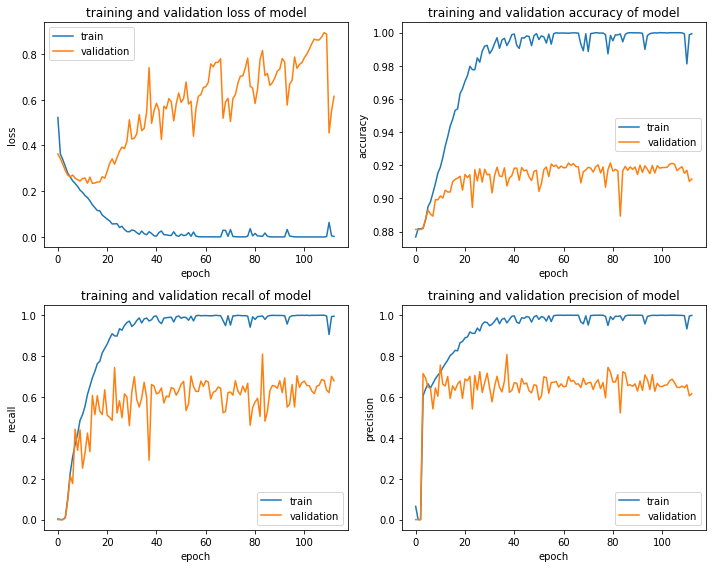

In [204]:
fig, ax = plt.subplots(2, 2, figsize = (10, 8))
ax = ax.ravel()
label = ["loss", "accuracy", "recall", "precision"]
for i in range(4):
    ax[i].plot(history.history[label[i]], label = "train")
    ax[i].plot(history.history['val_' + label[i]], label = "validation")
    ax[i].set_title('training and validation ' + label[i] + ' of model')
    ax[i].set_ylabel(label[i])
    ax[i].set_xlabel('epoch')
    ax[i].legend()

plt.tight_layout()

In [205]:
X_test = np.reshape(np.array(x_test_score_acc), (x_test_score_acc.shape[0], 1, x_test_score_acc.shape[1]))

In [206]:
model_lstm.evaluate(X_test, y_test_score_acc)

21/21 [==============================] - 1s 3ms/step - loss: 11.3761 - accuracy: 0.1577 - precision: 1.0000 - recall: 0.1577


[11.376081466674805, 0.1577380895614624, 1.0, 0.1577380895614624]

In [207]:
evaluate_random_pairs_graph(lst, model_lstm, lstm=True)

======== case 957 ========
202/202 [==============================] - 1s 3ms/step - loss: 0.0058 - accuracy: 0.9981 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          6444   12
======== case 84 ========
202/202 [==============================] - 1s 3ms/step - loss: 0.9643 - accuracy: 0.8849 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          5713  741
1             2    0
======== case 549 ========
202/202 [==============================] - 1s 3ms/step - loss: 0.1203 - accuracy: 0.9755 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          6298  158
======== case 90 ========
202/202 [==============================] - 1s 3ms/step - loss: 0.0592 - accuracy: 0.9904 - precision: 0.0000e+00 - recall: 0.0000e+00
Predicted   0.0  1.0
Actual              
0          6394   62
======== case 474 ========
202/202 [==============================] - 1s 3ms/step - l

In [208]:
result_eval_pairs1 = evaluate_pairs_graph(lst_eval, model_lstm, lstm=True)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


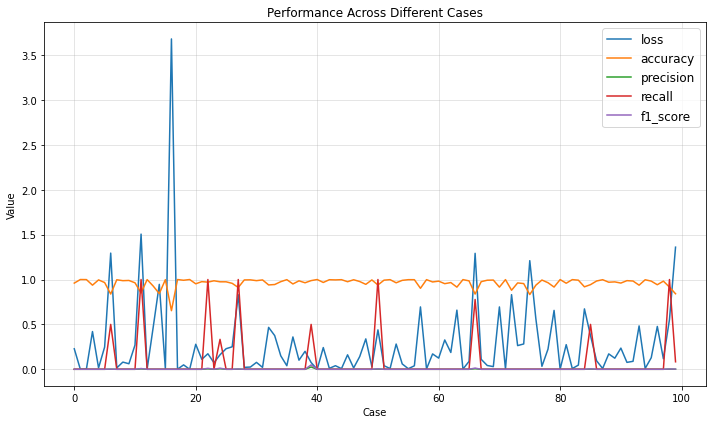

In [209]:
fig, ax = plt.subplots(figsize=(10, 6))
for col in result_eval_pairs1.columns:
    ax.plot(range(len(result_eval_pairs1)), result_eval_pairs1[col], label=col)
plt.legend(fontsize=12)
plt.xlabel("Case")
plt.ylabel("Value")
plt.title("Performance Across Different Cases")
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show()

## Conclusion

> Different representations have distinct performance. In our project, representations of words have low accuarcy abd high computational cost. And it's hard to capture the pair representations.

> After lots of experiments and thinking, we creatively develop a model - LawPairBERT, to overcome the shortcomings of other representations and achieve high accuracy in predicting the citations.

> In the table below, we compare the Performance of our LawPairBERT models. BERT embedding tend to perform better than the combined embeddings of both BERT and Graph in predicting pairs with citation relationship. However, combined embedding is better in predicting overall accuracy. And, as our expectation, using recall as the early stopping boosts the accuracy for predicting the true citation, while reducing the overall accuracy among different labels.

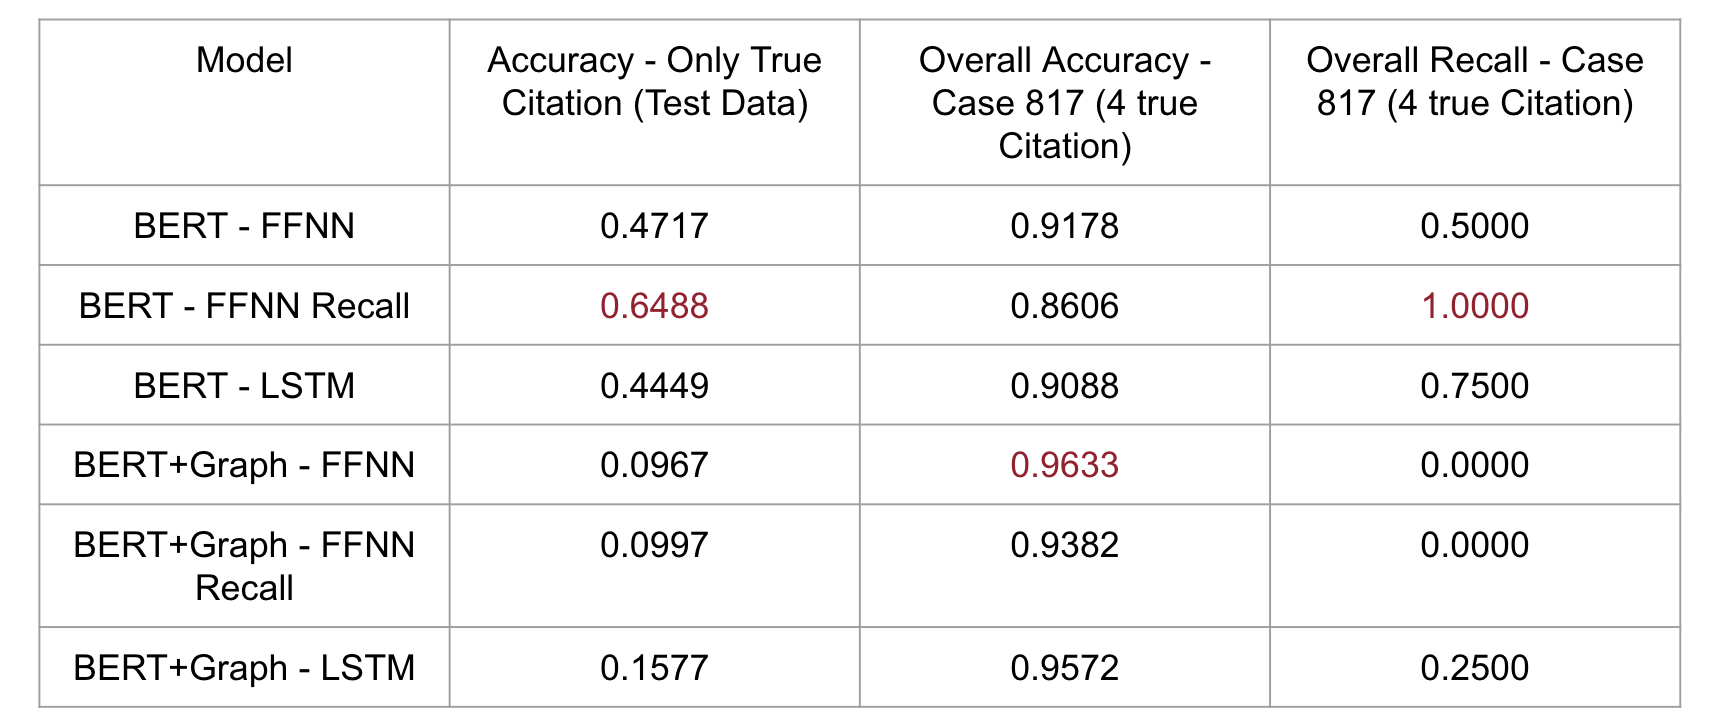

## Future Work

> 1. In the future, we desire to try more Graph Embedding method, like GCN, SDNE.

> 2. Validate and test our LawPairBERT model across more states.

> 3. Try to formalize our model in an more structured way. Ideally, we will also try to enable our model to be downloaded and installed through github.

## Appendix

[Return to top](#Notebook-contents)

## Model: FFNN for text classification

[Return to top](#Notebook-contents)

> The first model will be a simple Feed Forward Neural Network. The model has an Embedding layer followed by a Flatten layer and some Dense layers. The input and output of this FFNN model are the same as those of the BERT model. And as expected, the results are also similary to BERT model: FFNN encountered problems of having a gigantic size of classes and lack of fit.

In [210]:
import time
from tensorflow import keras

In [211]:
def build_ffnn():
    
  # Set the model name as
  model_name = 'ffnn_'+str(int(time.time()))

  # Create a FFNN Model
  model = tf.keras.models.Sequential(name=model_name)
  model.add(tf.keras.Input(shape=(SEQUENCE_SIZE)))
  model.add(tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_SIZE))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, activation="relu"))
  model.add(tf.keras.layers.Dense(42534,activation="sigmoid"))

  return model

In [212]:
learning_rate = 0.003
epochs = 10

In [213]:
VOCABULARY_SIZE = 50000
SEQUENCE_SIZE = 256 
EMBEDDING_SIZE = 100

In [214]:

# Build the model
model = build_ffnn()

# Print the model architecture
print(model.summary())
# Optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Model: "ffnn_1620691549"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 100)          5000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               13107712  
_________________________________________________________________
dense_3 (Dense)              (None, 42534)             21819942  
Total params: 39,927,654
Trainable params: 39,927,654
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
166/166 [==============================] - 9s 47ms/step - loss: 139.0211 - accuracy: 0.0000e+00 - val_loss: 5.0241 - val_accuracy: 0.0000e+00
Epoch 2/10
166/166 [==============================] - 8s 45ms/step - loss: 137.

In [215]:
test_data = tf.data.Dataset.from_tensor_slices((test_x_processed["input_ids"],
                                                test_x_processed["token_type_ids"],
                                                test_x_processed["attention_mask"]))

In [216]:
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [217]:

model.evaluate(validation_data)

37/37 [==============================] - 1s 15ms/step - loss: 4.9603 - accuracy: 0.0000e+00


[4.9602952003479, 0.0]

In [218]:
y_pred_ffnn= model.predict(test_data)
logits = tf.nn.softmax(y_pred_ffnn)
y_preds = np.argmax(logits, axis=1)

In [219]:
y_preds

array([27111, 12061, 27111, ..., 32304, 42448, 12061])

## Model: LSTM for text classification

[Return to top](#Notebook-contents)

> Build on the FFNN model,we added a bi-directional LSTM layer and got the LSTM model. In LSTM, We input each word, words relate to each other in some ways.
We make predictions at the end of the text when we see all the words in that text. This is not a good way to predict citations that also may occur within the text because these citations may not necessaily depend on the words at the end.

In [220]:
#### your code here

def build_lstm():
    
  # Set the model name as
  model_name = 'lstm'

  # Create a LSTM Model
  model = tf.keras.models.Sequential(name=model_name)
  model.add(tf.keras.Input(shape=(SEQUENCE_SIZE)))
  model.add(tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_SIZE))
  #model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=False)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, activation="relu"))
  model.add(tf.keras.layers.Dense(42534,activation="sigmoid"))

  return model

In [221]:
#### your code here
############################
# Training Params
############################

import time
from tensorflow.python.keras import backend as K
from tensorflow import keras

learning_rate = 2e-5
epochs = 10

VOCABULARY_SIZE = 50000
SEQUENCE_SIZE = 256 
EMBEDDING_SIZE = 100
# Free up memory
K.clear_session()
# Build the model
model = build_lstm()

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate, epsilon=1e-08)
# Loss
loss = keras.losses.CategoricalCrossentropy(from_logits=True)


# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 100)          5000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 42534)             21819942  
Total params: 26,970,470
Trainable params: 26,970,470
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
166/166 [==============================] - 15s 71ms/step - loss: 138.2908 - accuracy: 0.0000e+00 - v

In [222]:
model.evaluate(validation_data)

37/37 [==============================] - 1s 21ms/step - loss: 4.9990 - accuracy: 0.0000e+00


[4.999049663543701, 0.0]

In [223]:
y_pred_lstm = model.predict(test_data)
logits = tf.nn.softmax(y_pred_lstm)
y_preds = np.argmax(logits, axis=1)

In [224]:
y_preds

array([10788, 27111, 27111, ..., 10788, 42448, 27111])

# EDA

[Return to top](#Notebook-contents)


## Data Description for EDA
**Case Law data**
The data is available through Harvard Law School Case Law Access Project. The data mainly falls in two categories: i) bulk export: zip files of case text and metadata by jurisdiction or reporter, and ii) citation graph: a zipped CSV file of case ids and the case ids they cite to. The main data sets we used here are the latest case metadata and text for each case by the jurisdiction in Arkansas, Illinois,  North Carolina, and New Mexico.


In [225]:
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import lzma
import json
import requests
from tqdm import tqdm
from collections import Counter
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.decomposition import PCA
import os
%matplotlib inline

## Downloading data
We first looked at the total cases in the four states

In [226]:
## ark/, ill/, nc/, nm/
state_names = ['ark', 'ill', 'nc', 'nm']
for state in state_names:
  download_url = "https://case.law/download/bulk_exports/20210421/by_jurisdiction/case_text_open/"+ state + "/" + state + "_text_20210421.zip"
  output_path = "data/"+ state+"_text.zip"
  print("Downloading to %s ..." % output_path)
  with open(output_path, 'wb') as out_file:
      shutil.copyfileobj(requests.get(download_url, stream=True).raw, out_file)
  print("Done.")



Done.
Done.
Done.
Done.


# Loading data

Our bulk export is stored as a zipped folder in [BagIt](https://en.wikipedia.org/wiki/BagIt) format, which in turn
contains an xzipped file in [jsonlines](http://jsonlines.org/) format. We can peel off all of those layers and get
a list of cases with built-in Python libraries.

Let's pull 1-year batches of cases at 10 year intervals from 1900 to 2000. This should give us a good sampling over time.

In [227]:
# a list to hold the cases we're sampling
# decompress the file line by line
def load_cases(state):
  cases = []
  filename = 'data/'+ state +'_text.zip'
  with zipfile.ZipFile(filename, 'r') as zip_archive:
      xz_path = next(path for path in zip_archive.namelist() if path.endswith('/data.jsonl.xz'))
      with zip_archive.open(xz_path) as xz_archive, lzma.open(xz_archive) as jsonlines:
          for line in tqdm(jsonlines):
              # decode the file into a convenient format
              record = json.loads(str(line, 'utf-8'))
              # if the decision date on the case matches one we're interested in, add to our list
              if int(record['decision_date'][:4]) in range(1900, 2010, 10):
                  cases.append(record)  
  print(filename+'\n')
  print("Number of Cases: {}".format(len(cases)))
  return cases

cases = []
for state in state_names:
  cases+=load_cases(state)
print(len(cases))

59617it [00:20, 2882.77it/s]
707it [00:00, 7061.79it/s]

data/ark_text.zip

Number of Cases: 5020


183033it [01:06, 2736.08it/s]
489it [00:00, 4889.28it/s]

data/ill_text.zip

Number of Cases: 15093


97429it [00:29, 3260.16it/s]
145it [00:00, 1391.34it/s]

data/nc_text.zip

Number of Cases: 7100


18337it [00:09, 1887.52it/s]

data/nm_text.zip

Number of Cases: 1672
28885


# Analyzing case metadata
Let's take a look at the case format by accessing the first entry in our list of matching cases.

In [228]:
cases[0]

{'analysis': {'cardinality': 1235,
  'char_count': 29615,
  'ocr_confidence': 0.755,
  'pagerank': {'percentile': 0.9685973876259049, 'raw': 7.40755520271773e-07},
  'sha256': '7857d8e0fe598e76aef4ae9c4c856733089782955fa457e665633c82dfe5d70f',
  'simhash': '1:0b6add2e73acd37a',
  'word_count': 4935},
 'casebody': {'data': {'attorneys': ['Bowden & Kendel, by: David O. Bowden; William H. Craig; and David R. Cannon, for appellant.',
    'Mark Pryor, Att’y Gen., by: Michael C. Angel, Ass’t Att’y Gen., for appellee.'],
   'corrections': '',
   'head_matter': 'Trent HARMON v. STATE of Arkansas\nCR 98-1354\n8 S.W.3d 472\nSupreme Court of Arkansas\nOpinion delivered January 6, 2000\n[Petition for rehearing denied February 10, 2000. ]\nBowden & Kendel, by: David O. Bowden; William H. Craig; and David R. Cannon, for appellant.\nMark Pryor, Att’y Gen., by: Michael C. Angel, Ass’t Att’y Gen., for appellee.\nCORBIN, J., not participating.',
   'judges': ['Arnold, C.J., Thornton, J., and Special Jus

A lot of info here, but it's quite messy. Let's pull out a few case metadata attributes we're interested in, leaving the actual case text aside for now – the decision date (year only), case name, case citation, court, and opinion count. We'll put them into a Pandas Dataframe for easier manipulation. 

In [229]:
# use a list comprehension to pull out the metadata attributes specified above
case_metadata = [{'year': int(case['decision_date'][:4]),
                'name': case['name'],
                'citation': case['citations'],
                'cites_to':case['cites_to'],
                'court': case['court']['name'],
                #'state': case['court']['name_abbreviation'],
                'opinion_count': len(case['casebody']['data']['opinions'])} 
                 for case in cases]

# lists of dictionaries like `case_metadata` convert easily into Dataframes
metadata_df = pd.DataFrame(case_metadata)
metadata_df.head()

year  ... opinion_count
0  2000  ...             2
1  1970  ...             1
2  1900  ...             1
3  1910  ...             1
4  1970  ...             1

[5 rows x 6 columns]

First, let's check how many cases we have from each year in our sample. 

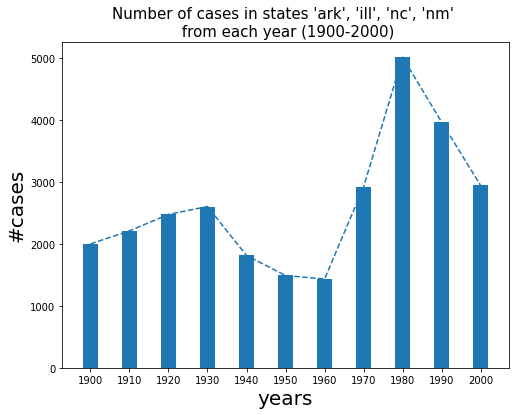

In [230]:
year_count = metadata_df['year'].value_counts().sort_index()
plt.figure(figsize=(8,6))
plt.plot(year_count.index, year_count.values,'--')
plt.bar(year_count.index, year_count.values,  width=4)
plt.title("Number of cases in states 'ark', 'ill', 'nc', 'nm' \n from each year (1900-2000)",fontsize=15)
plt.xticks(year_count.index)
plt.xlabel('years',fontsize=20)
plt.ylabel('#cases', fontsize=20)
plt.show()

We find there is a lot of variation inpublication volume year to year, with pronounced increases before 1980 and decreases after 1980. We then break it down to court level.

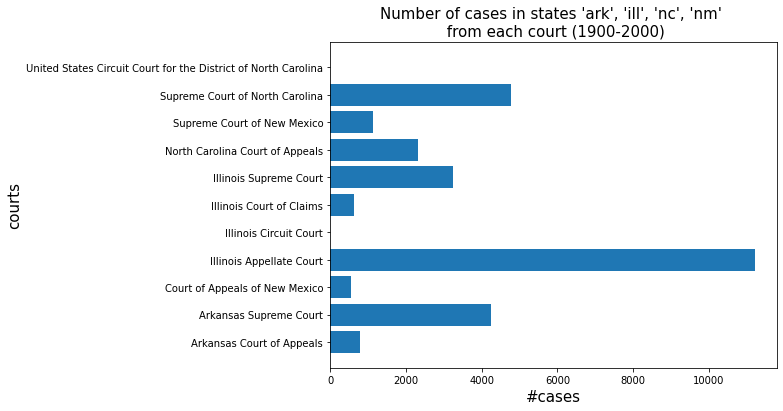

In [231]:
court_count = metadata_df['court'].value_counts().sort_index()
plt.figure(figsize=(8,6))
plt.barh(court_count.index, court_count.values)
plt.title("Number of cases in states 'ark', 'ill', 'nc', 'nm' \n from each court (1900-2000)", fontsize=15)
plt.ylabel('courts',fontsize=15)
plt.xlabel('#cases', fontsize=15)
plt.show()

we see the cases are mostly from the Illinois Appellate Court, Supreme Court of NorthCarolina, and Arkansas Supreme Court, with Illinois ranking highest. The state of New Mexico has far fewercases.

### Opinions
A judicial opinion is a form of legal opinion written by a judge or a judicial panel in the course ofresolving a legal dispute, providing the decision reached to resolve the dispute, and usually indicating the factswhich led to the dispute and an analysis of the law used to arrive at the decision. There are usually fall thefollowing category: majority (agreed to by more than half of the members of a court), dissent (written by one or more judges expressing disagreement with the majority opinion), andper curiamdecision (one rendered byat least the majority of court acting collectively and anonymously). Notice that opinions can exist concurrentlyin the documentation of one case.

We first count the number of opinions of the case.  We can see that the majority of our cases have a single opinion.

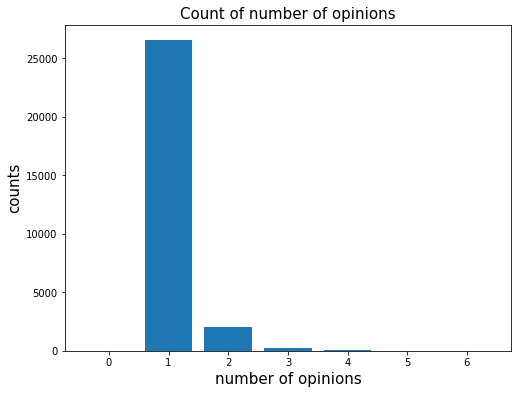

In [232]:
opinion_count = metadata_df['opinion_count'].value_counts().sort_index()
plt.figure(figsize=(8,6))
plt.bar(opinion_count.index, opinion_count.values)
plt.title("Count of number of opinions", fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.xlabel('number of opinions', fontsize=15)
plt.show()

If we combine the counts with time trend, in more recent times such as 1980, 1990,and 2000, cases started to have more than one opinions.

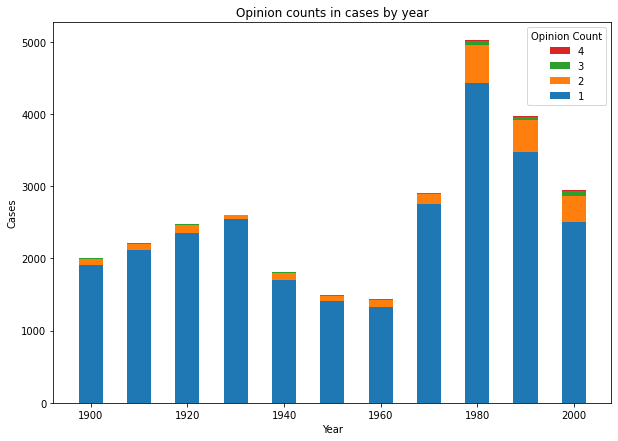

In [233]:
# get frequency of opinion counts for each year
n_opinions = [[year, 
               metadata_df[(metadata_df['year'] == year) & (metadata_df["opinion_count"] == 1)].shape[0],
               metadata_df[(metadata_df['year'] == year) & (metadata_df["opinion_count"] == 2)].shape[0],
               metadata_df[(metadata_df['year'] == year) & (metadata_df["opinion_count"] == 3)].shape[0],
               metadata_df[(metadata_df['year'] == year) & (metadata_df["opinion_count"] >= 4)].shape[0]]
              for year in metadata_df['year'].unique()]

# reformat for graph
n_opinions = list(zip(*n_opinions))
n_opinions = [list(item) for item in n_opinions]
plt.figure(figsize=(10,7))

ind = n_opinions[0]
handles = []
for i, count in enumerate(n_opinions[1:]):
    bot = n_opinions[1:i+1]
    bot = [sum(x) for x in zip(*n_opinions[1:i+1])]
    bot = [0]*len(ind) if not bot else bot
    h = plt.bar(ind, count, 5, bottom=bot, label=i+1)
    handles.append(h)
    
plt.legend(handles=handles[::-1], title="Opinion Count")
plt.xlabel("Year")
plt.ylabel("Cases")
plt.title("Opinion counts in cases by year")
plt.show()

Interesting – it seems that cases from 1980, 1990, and 2000 tend to have more opinions than those from earlier years in the sample.

## Analyzing case text

It is intuitive for us to take a closer look into the opinion texts. To keep it simple, we separate one opinion perrow in our opinion dataframe. For the cases with two or more opinions, multiple rows will be occupied byopinions of the same id. After dropping unnecessary information, for each opinion, we will have the followingattributes:  case id, case name, court, citations, author (if known), the type of opinion, and the text body.


In [234]:
#Loop through cases and build rows with case metadata AND opinion metadata/text.
#We load in all of the keys initially, then modify the ones we want to.

opinion_data = []
for case in cases:
    for opinion in case["casebody"]["data"]["opinions"]:
        opinion_data.append({
            'id': case['id'],
            'name': case['name'],
            'decision_date': int(case['decision_date'][:4]),
            'court': case['court']['name'],
            'citation': case['citations'],
            'author': opinion['author'],
            'type': opinion['type'],
            'text': opinion['text'],
        })

opinions_df = pd.DataFrame(opinion_data)
opinions_df.head()

id  ...                                               text
0  1365128  ...  ANNABELLE Clinton Imber, Justice.\nAppellant T...
1  1365128  ...  Ray Thornton, Justice,\ndissenting. To be conv...
2  1597745  ...  John A. Fogleman, Justice.\nAppellant, Univers...
3  1334075  ...  Riddick, J.\n(after stating the facts.) The ma...
4  1545399  ...  Battue, J.\nHenry Harding was indicted by a gr...

[5 rows x 8 columns]

After dropping some extraneous information, we're left with a number of useful attributes for each opinion:

- id (assigned by CAP database): A unique case identifier that we can use to link opinions belonging to the same case
- name: The case's name
- court: The court in which the case was heard and decided
- citations: The official citation to the case
- author: The author of the opinion, if known
- type: The type of the opinion (ex. 'majority,''dissent,''concurrence')
- text: The full text of the opinion



In the Figure below,we find the “majority” opinion is the most common type, followed by “dissent” and“concurrence”.

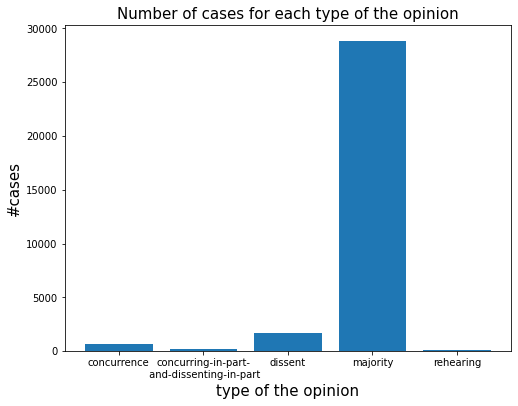

In [235]:
type_count = opinions_df['type'].value_counts().sort_index()
name = ['concurrence', 'concurring-in-part-\n and-dissenting-in-part', 'dissent','majority', 'rehearing']
plt.figure(figsize=(8,6))
plt.bar(name, type_count.values)
plt.title('Number of cases for each type of the opinion',fontsize=15)
plt.xlabel('type of the opinion',fontsize=15)
plt.xticks(name,fontsize=10)
plt.ylabel('#cases', fontsize=15)
plt.show()

In [236]:
opinions_df['length'] = opinions_df['text'].map(lambda x: len(str(x).split()))
print('max length: {} words'.format(opinions_df['length'].max()))
print('min length: {} words'.format(opinions_df['length'].min()))

max length: 63611 words
min length: 2 words


The number of words in opinion has a wide range. The longest opinion has over 60,000 words,and most opinions have fewer than 10,000 words. 

Text(0.5, 0, 'number of words')

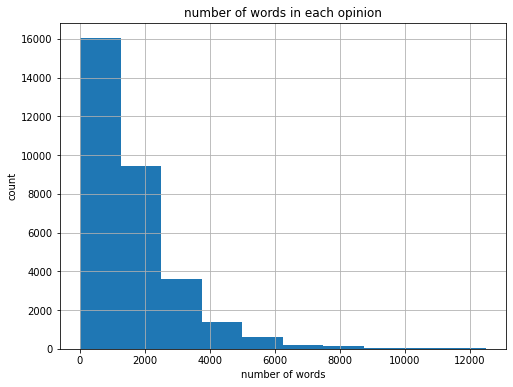

In [237]:
plt.figure(figsize=(8,6))
opinions_df['length'][opinions_df['length']<12500].hist()
plt.title('number of words in each opinion')
plt.ylabel('count')
plt.xlabel('number of words')

In [238]:
opinions = []
for i in range(len(opinions_df)):
    if opinions_df['text'][i] != None:
        opinions.append(opinions_df['text'][i].split())
words = []
for word in opinions:
    words += word

We also interested in the most frequent words in opinions. From the plot below, we found it's better to remove the stop words before plotting.

<Figure size 432x288 with 0 Axes>

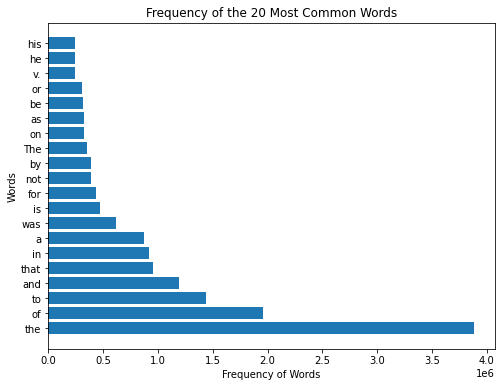

In [239]:
 common_words = FreqDist(words).most_common(20)
x, y = zip(*common_words)

plt.figure()
plt.figure(figsize=(8,6))
plt.barh(x, y)
plt.title('Frequency of the 20 Most Common Words')
plt.ylabel('Words')
plt.xlabel('Frequency of Words')
plt.show()

In [240]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

for i, w in enumerate(words):
    if w=='The':
        words[i] = 'the'
    if w=='In':
        words[i] = 'in'

word_count = Counter(words)
most_words = word_count.most_common()
x, y = [], []
for word, count in most_words:
    if (word not in stop_words):
        x.append(word)
        y.append(count)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text(0.5, 1.0, 'Frequency of the 20 Most Non-stop Words')

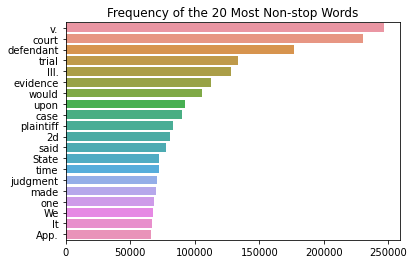

In [241]:
import seaborn as sns
sns.barplot(x=y[0:20], y=x[0:20]).set_title('Frequency of the 20 Most Non-stop Words')

After dropping the English stop-words, we found that themost frequent words are shown in the above figure.

We can even compare the opinion style (i.e. the distinctive words used) across time.   Comparing cases from 1900, 1910, 1920, and 1930 against cases from 1970, 1980, 1990, and 2000, what words can we say are distinctive to each time period? Are there words from opinions dating to the beginning of the 20th century that don't occur in opinions dating to the end of the 20th century?

We'll start by implementing a basic n-gram search function and graphing our results. 

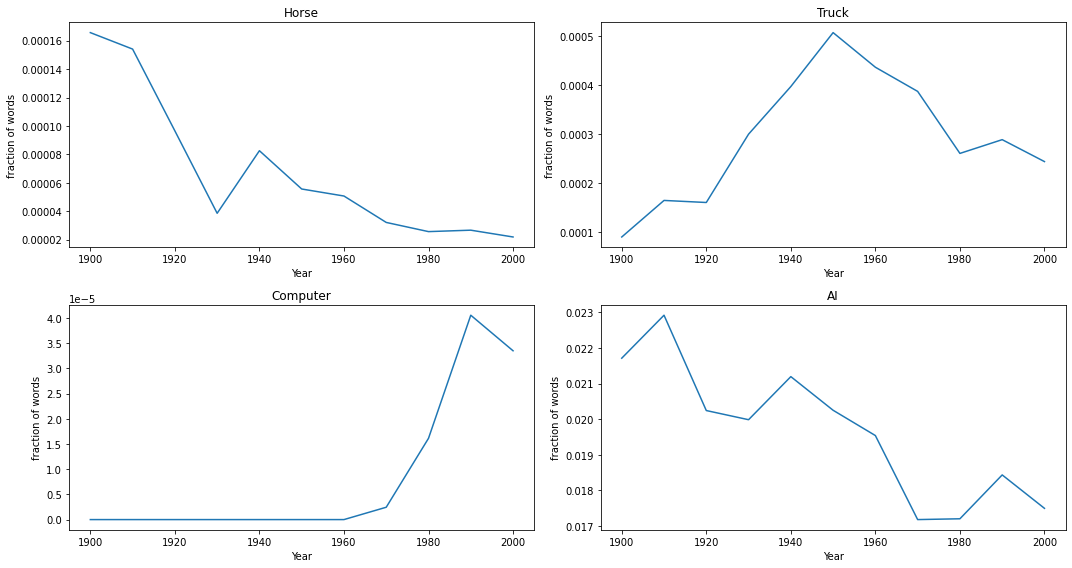

In [242]:
def search_ngram(ngram):
    pairs = []
    for year in opinions_df["decision_date"].unique():
        temp = opinions_df[opinions_df["decision_date"] == year]["text"].tolist()
        temp = " ".join(temp).lower()
        n = len(temp.split(" "))
        ngram_count = temp.count(ngram.lower())
        pairs.append((year, ngram_count/n))
    pairs.sort()
    return pairs

def graph_ngram(pairs, ax, title):
    x,y = [list(x) for x in zip(*pairs)]
    ax.plot(x,y)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("fraction of words")
    return ax

fig, axes = plt.subplots(2, 2, figsize=(15,8))
graph_ngram(search_ngram("horse"), axes[0,0], "Horse")
graph_ngram(search_ngram("truck"), axes[0,1], "Truck")
graph_ngram(search_ngram("computer"), axes[1,0], "Computer")
graph_ngram(search_ngram("ai"), axes[1,1], "AI")
plt.tight_layout()
plt.show()

We observe some interesting trends here that the use of horse and AI has diminished. However, the use ofcomputer has increased as expected.

We also find a list of words which occur fewer than 10 
times in cases from 1900-1940 but frequently in cases from 1970-2000.

In [243]:
def tokenize_cases(cases):
    cases = " ".join(cases).lower()
    cases = cases.replace("\n", " ").replace(",", "").replace(";", "").replace("'", "").replace("’", "")
    cases = cases.replace("(", "").replace(")", "").replace(".", "").replace("?", "").replace("!", "").split(" ")
    return cases

early_cases = tokenize_cases(opinions_df[opinions_df["decision_date"] <= 1930]["text"].tolist())
late_cases = tokenize_cases(opinions_df[opinions_df["decision_date"] >= 1970]["text"].tolist())

early_cases_dict = {}

for word in early_cases:
    if word in early_cases_dict:
        early_cases_dict[word] += 1
    else:
        early_cases_dict[word] = 1

new_words_dict = {}

for word in late_cases:
    if word in early_cases_dict:
        if early_cases_dict[word] < 10:
            if word in new_words_dict:
                new_words_dict[word] += 1
            else:
                new_words_dict[word] = 1
    else:
        if word in new_words_dict:
            new_words_dict[word] += 1
        else:
            new_words_dict[word] = 1

def isInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

sorted_new_words = sorted(new_words_dict.items(), key=lambda x:-x[1])
sorted_new_words = [item for item in sorted_new_words if not isInt(item[0])]
sorted_new_words = sorted_new_words[:100]

print("Most common words from 1970-2000 that occured <10 times from 1900-1930\n")
print ("{0:14}|{1:5}".format("Word", "Occurances"))
print ("-------------------------")
for word in sorted_new_words:
    print ("{0:14}|{1:5}".format(word[0], word[1]))

Most common words from 1970-2000 that occured <10 times from 1900-1930

Word          |Occurances
-------------------------
ne2d          |56861
nc            |33055
se2d          |19303
p2d           |13269
nm            |11132
sw2d          | 9808
gs            | 9064
ilcs          | 6375
coverage      | 6147
***           | 5866
pm            | 4419
f2d           | 4373
cert          | 3878
factual       | 3791
ill2d         | 3720
ncgs          | 3312
eg            | 3147
cocaine       | 3050
allegedly     | 2998
problems      | 2882
procedures    | 2855
initially     | 2808
sct           | 2661
additionally  | 2655
miranda       | 2590
ne            | 2497
post-conviction| 2373
aggravating   | 2239
program       | 2218
post-trial    | 2146
pretrial      | 2118
trier         | 2074
third-party   | 2035
parking       | 2005
facility      | 1995
visitation    | 1925
[sic]         | 1908
repl          | 1887
app2d         | 1882
“[t]he        | 1864
lineup        | 1859
emotional     

Based on our EDA, we would like to study word-to-word similarity and further study case-to-case similarity.Then, based on the similarity distance between cases, for a test case law, we want to predict the citations associated with it.